In [7]:
#Import libraries

import gzip #for parsing gz files
import pandas as pd
import re 
import inflect #numeric/cardinal

In [8]:
dirPath = r"C:\Study\Projects\NLP\data"
reviewPath = r"reviews_Tools_and_Home_Improvement_5.json.gz"
reviewPath = r"reviews_Musical_Instruments_5.json.gz"
qaPath = r"C:\Study\Projects\NLP\data" 
path = dirPath + "\\" + reviewPath

In [9]:
dataFile = gzip.open(path, 'r')

In [10]:
# Need this function because large amount of data we are going to load up

# http://jmcauley.ucsd.edu/data/amazon/index.html
# eval function allows text to be parsed as python code
# parse function is a generator with yield
# yield when we want to iterate over a sequence, but don't want to store the entire sequence in memory
def parse(dataFile):
    for each in dataFile:
        yield eval(each)

In [11]:
# for each review for a product in dataFile maps dict[nth] = review (nth)
# enumerate can't be used on a generator
count = 0
productReviews = {}
for eachReview in parse(dataFile):
    productReviews[count] = eachReview
    count = count + 1


In [144]:
len(productReviews)

10261

In [12]:
productsReviewData = pd.DataFrame.from_dict(productReviews, orient='index')

In [13]:
reviewTextProcessing = pd.DataFrame(productsReviewData.reviewText.copy())

In [14]:
productsReviewData.dtypes
len(productsReviewData)
reviewTextProcessing.shape

(10261, 1)

In [164]:
reviewTextProcessing.head(5)

,reviewText
0,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...
2,The primary job of this device is to block the...
3,Nice windscreen protects my MXL mic and preven...
4,This pop filter is great. It looks and perform...


In [11]:
# reduce the data set to test text cleaning /processing before tokenizing
productsReviewData = productsReviewData.iloc[:1500, :]


In [31]:
df = productsReviewData
testSample = df.loc[df['asin']=='B00004Y2UT', ['reviewText']]


In [33]:
sampleText = testSample['reviewText'].to_list()
T = sampleText

In [23]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
import Contractions_Words as contractions

contractions_dict = contractions.contractions_dict

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    s = re.sub("\*", "#", s)    
    def replace(match):
         return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [16]:
sample = "I don\'t know what to say nay. I haven\'t"
expand_contractions(sample)

'I do not know what to say nay. I have not'

In [2]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

# https://towardsdatascience.com/introduction-to-natural-language-processing-for-text-df845750fb63



In [17]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string

lemmatizer = WordNetLemmatizer()
#print(sample)
stopWords = set(stopwords.words('english'))

# return both wholeText, paragraph Text
def singleReviewCleanUp(sample):
    #print(sample)
    #sample = sample.decode("utf-8")
    sample = expand_contractions(sample)
    sample = sample.lower()
    
    #for word in sample:
    #    print(lemmatizer.lemmatize(word, wordnet.VERB))
    
    review = sent_tokenize(sample)
    #print(review)
    for count, eachSent in enumerate(review):
        #remove numbers
        eachSent = re.sub("r'\d+/\d+|\d+|\$\d+.\d+", " ", eachSent)
        #remove string
        eachSent = re.sub('[%s]' % re.escape(string.punctuation), ' ', eachSent)
        #word tokens
        #print([lemmatizer.lemmatize(text, wordnet.VERB) for text in eachSent.split()])
        eachSent = word_tokenize(eachSent)
        review[count] = eachSent
        # lemmatize and remove stopWords
        #eachSent = [word for word in eachSent if not word in stopWords]
        #eachSent = [lemmatizer.lemmatize(word, wordnet.VERB) for word in eachSent]
        #eachSent = [lemmatizer.lemmatize(word, wordnet.VERB) for word in eachSent if not word in stopWords]
        review[count] = " ".join(eachSent)
    wholeText = [" ".join(review) ]
    paragraphText = review
    #return wholeText
    #return paragraphText
    return paragraphText, wholeText

#paragraphText, wholeText = singleReviewCleanUp(sample)
#wholeText, paragraphText
#paragraphText

In [18]:
#Give me back text in a paragraph sentence forms. They do have more values than a clobbed of text based on Polarity Check.
cleanUpTextParagraph = lambda text: singleReviewCleanUp(text)[0]


In [24]:
sample = " I don't know what to do. I need to test through though. Do you have any suggestions. What s***"
result = cleanUpTextParagraph(sample)
result

['i do not know what to do',
 'i need to test through though',
 'do you have any suggestions',
 'what shit']

In [26]:
from textblob import TextBlob

# need to do a data check first
def getPolaritySubjectivity(data):
    #print(data)
    paragraphText = data
    sumPolarity = []
    sumSubjectivity = []
    for each in paragraphText:
        sumPolarity.append(TextBlob(each).sentiment.polarity)
        sumSubjectivity.append(TextBlob(each).sentiment.subjectivity)
    print("sumPol", sumPolarity)
    return sum(sumPolarity), sum(sumSubjectivity)

    #print(each, TextBlob(each).sentiment.polarity, TextBlob(each).sentiment.subjectivity)
#(sample2, TextBlob(sample2).sentiment.polarity, TextBlob(sample2).sentiment.subjectivity)


In [35]:
#Return the sume of polarity in a paragraph sentence when give a text in a list form of sentence

getPolarityFromText = lambda text: getPolaritySubjectivity(text)[0]

for each in sampleText:
    sample = cleanUpTextParagraph(each)
    print(sample, getPolarityFromText(sample))

In [37]:
%%time
reviewTextProcessing['Processed'] = reviewTextProcessing.reviewText.apply(cleanUpTextParagraph)


Wall time: 13 s


In [512]:
reviewTextProcessing.Processed[0]

['not much to write about here but it does exactly what it has it is supposed to',
 'filters out the pop sounds',
 'now my recordings are much more crisp',
 'it is one of the lowest prices pop filters on amazon so might as well buy it they honestly work the same despite their pricing']

In [353]:
#sentiment = lambda text: TextBlob(text).sentiment.polarity

In [354]:
adjustSentimentModel = lambda x: 0.0 if x < 0.0 else 1.0

In [526]:
%%time
reviewTextProcessing['Sentiment']= reviewTextProcessing.Processed.apply(getPolarityFromText)

sumPol [0.075, 0.0, 0.375, 0.3]
sumPol [0.0625, -0.5, 0.0]
sumPol [0.32, 0.0, 0.2, -0.1875]
sumPol [0.6, 0.1]
sumPol [0.8, 0.0, 0.0]
sumPol [0.7, 0.15, 0.325, 0.0, 0.2, 0.8]
sumPol [0.7, 0.3, 0.0]
sumPol [0.0, 0.0, -0.16822727272727273, 0.0, 0.0, 0.15]
sumPol [1.0, 0.0, 0.0, 0.0]
sumPol [1.0, 0.3833333333333333, -0.5]
sumPol [0.054000000000000006, -0.037500000000000006, 0.14666666666666667, 0.0, 0.21428571428571427, 0.125]
sumPol [0.0, 0.09999999999999999, 0.7, 0.0]
sumPol [-0.19107142857142856]
sumPol [0.65]
sumPol [0.0, 0.0]
sumPol [0.0, -0.125, 0.4, 0.0, 0.11875, 0.1, 0.35]
sumPol [1.0, -0.05, 0.4, 0.23666666666666666]
sumPol [0.525]
sumPol [0.375, 0.0, 0.125, -0.039999999999999994, 0.25, -0.21354166666666666, 0.028124999999999997, 0.125, 0.26, 0.2642857142857143, 0.6, 0.0, 0.5, 0.34500000000000003]
sumPol [0.8, 0.45]
sumPol [0.375, -0.22499999999999992, 0.0, 0.5, 0.21166666666666667, -0.16666666666666666, -0.3, 0.24999999999999997]
sumPol [0.235]
sumPol [0.9099999999999999, 0.4, -0

sumPol [0.3103896103896103, 0.4125, 0.3666666666666667, 0.0, -0.19444444444444445, 0.29375, 0.0, 0.15330578512396695]
sumPol [0.0, 0.0, 0.1, 0.041666666666666685, 0.39, 0.0, 0.027777777777777773, 0.0, 0.17113095238095236, 0.0, -0.5, 0.5666666666666667, 0.25, 0.25, 0.008333333333333331, 0.0]
sumPol [0.06666666666666665, 0.2, 1.0, 0.15000000000000002]
sumPol [-0.2]
sumPol [0.0, 0.4166666666666667]
sumPol [0.1976190476190476]
sumPol [-0.25, 0.07, 0.20972222222222223, 0.4]
sumPol [0.0, 0.0]
sumPol [-1.0, -0.2, -0.33809523809523806]
sumPol [0.5, 0.35]
sumPol [0.0, 0.07777777777777778, 0.19166666666666665, 0.19399470899470903, 0.14722222222222223, 0.4, 0.3666666666666667, 0.18124999999999997, 0.0, 0.0, 0.22777777777777777, 0.125, -0.5, 0.125, 0.1]
sumPol [0.5533333333333333]
sumPol [0.07083333333333335, 0.30000000000000004, 0.0]
sumPol [0.4166666666666667, 0.0, 0.0]
sumPol [0.0, 0.0, 0.34940476190476194, 0.0, 0.0]
sumPol [0.15833333333333333, 0.35, 0.3416666666666667]
sumPol [0.0952380952380

sumPol [0.6428571428571428, 0.3, 0.5, -0.05, 0.0, 0.0, 0.4, 0.05, 0.09208333333333334, 0.3816666666666667, -0.2]
sumPol [-0.25, -0.37777777777777777, -0.38125, 0.47333333333333333, -0.12840909090909092, 0.06818181818181818, 0.09166666666666667, 0.12646103896103894, 0.14999999999999997, 0.5900000000000001, 0.12767857142857142]
sumPol [0.5444444444444445, 0.06805555555555556, 0.0, 0.0, 0.0, 0.2]
sumPol [-0.23333333333333334, 0.0, 0.15400000000000003, -0.1625, 0.1, 0.5, 0.3, 0.05000000000000002, 0.2, 0.3]
sumPol [0.3, -0.19444444444444442, -0.017708333333333336, 0.32, 0.32, 0.125]
sumPol [0.12166666666666667, -0.2953125, 0.0, 0.5, -0.1, 0.1, 0.03333333333333333, 0.025, 0.0]
sumPol [0.0, 0.19821428571428573, 0.0, 0.0, 0.2555555555555556, 0.4, 0.2833333333333333, 0.5, 0.2787878787878788, -0.15555555555555559, 0.25, 0.55, 0.25555555555555554, 0.2375, 0.30000000000000004, 0.2375, 0.0, 0.2625, 0.2880952380952381, 0.3055555555555556]
sumPol [0.1, 0.0, 0.6, 0.8]
sumPol [0.39585714285714285]
sumP

sumPol [0.02500000000000001, 0.0, -0.05, 0.1, 0.0, 0.75, -0.18333333333333335, 0.0, 0.0, 0.2, 0.15, -0.78, 0.25555555555555554, 0.20249999999999999, 0.8, 0.0, 0.5, 0.0, 0.4, 0.13363756613756614, 0.34375, -0.3333333333333333, 0.0]
sumPol [0.0, 0.0, 0.1125, 0.0, 0.0, 0.25, -0.17666666666666667, -0.025, 0.25, 0.19166666666666668, 0.1515151515151515]
sumPol [1.0, 0.0, 0.55, 0.0, 0.0]
sumPol [0.0, 0.18333333333333335, 0.0]
sumPol [0.44999999999999996, 0.3]
sumPol [0.0, 0.1875, 0.5444444444444444, 0.4, 0.2]
sumPol [-0.6999999999999998, 0.22500000000000003, 0.0, 0.1733333333333333]
sumPol [0.0, 0.0, 0.12738095238095237]
sumPol [1.0, 0.7166666666666667, 0.2, 0.0]
sumPol [0.0, 0.13636363636363635, 0.21666666666666665]
sumPol [0.15833333333333333]
sumPol [0.0, 0.0, 0.2]
sumPol [0.25, -0.17857142857142858, 0.0]
sumPol [0.0, 0.25, 0.43333333333333335, 0.3333333333333333, 0.0, -0.16666666666666666, 0.5, -0.09999999999999999, 0.0, 0.4, 0.0, 0.16]
sumPol [0.65, -0.08333333333333333]
sumPol [0.0681818

sumPol [0.5, 0.0, 0.1]
sumPol [1.0, 0.43333333333333335, 0.0, 0.43333333333333335, -0.3125, 0.4166666666666667, 0.7]
sumPol [0.14285714285714285, 0.7]
sumPol [0.35, 0.0, 0.0]
sumPol [0.0, 0.10000000000000002]
sumPol [0.0, 0.2, 0.7083333333333334, 0.13333333333333333, 0.0]
sumPol [0.35, 0.0]
sumPol [0.6, 0.8, 0.0]
sumPol [0.43333333333333335, 0.25, 0.7]
sumPol [0.43, 0.11666666666666665, 0.5]
sumPol [0.7, 0.09999999999999998]
sumPol [0.0, 0.0, 0.5]
sumPol [0.8, 0.3444444444444444]
sumPol [0.25, 0.5, 0.5333333333333333]
sumPol [0.0, 0.4541666666666667]
sumPol [0.05833333333333335]
sumPol [0.11363636363636363, 0.14069264069264067, 0.26666666666666666, 0.5, 0.5952380952380952, 0.25, 0.1]
sumPol [0.0, 0.0, 0.2, 0.025, -0.125, 0.4]
sumPol [0.8, 0.15079365079365079, -0.125, 0.13, 0.0, 0.0]
sumPol [0.0, 0.10833333333333334, -0.12222222222222223, 0.0, 0.3424242424242424, 0.6]
sumPol [0.1, 0.0, 0.32142857142857145, 0.18, 1.0, 0.0, 0.0]
sumPol [0.3416666666666667, 0.5, 0.0, 0.21666666666666665]
s

sumPol [0.0, 0.5]
sumPol [1.0, -0.01979166666666668]
sumPol [-0.2, 0.4388888888888889]
sumPol [0.8, 0.5]
sumPol [0.20677083333333332]
sumPol [0.17500000000000004, -0.05, 0.4666666666666666, 0.1, 0.027777777777777766]
sumPol [0.0, 0.4888888888888889, 0.0]
sumPol [0.0, 0.0, -0.09999999999999999, 0.0, 0.08333333333333333, -0.12916666666666665, 0.2614285714285714, 0.7]
sumPol [1.0, 0.51, 0.65, 0.01428571428571429, 0.9]
sumPol [-0.03571428571428572, 0.08124999999999999]
sumPol [-0.45, 0.0, 0.45]
sumPol [0.5, 0.3333333333333333]
sumPol [0.5, 0.625, 0.0, 0.006666666666666687]
sumPol [0.8, 0.0]
sumPol [0.5, 0.14285714285714285, 0.0]
sumPol [0.0, 0.2, -0.4, 0.05000000000000002, 0.0, 0.45, 0.4666666666666667]
sumPol [0.5, 0.5, 0.30000000000000004]
sumPol [0.2, 0.8]
sumPol [-0.00833333333333334, 0.0, 0.5, -0.3458333333333333, 0.039999999999999994, -0.065, -0.05, -0.1, 0.202, -0.75]
sumPol [0.07499999999999998, -0.15000000000000002, 0.10000000000000002, 0.0]
sumPol [0.8, 0.5]
sumPol [0.8, -0.5]
su

sumPol [0.0, 0.35, -0.6, 0.75, -0.04583333333333334, -0.9, 0.10000000000000002, 0.0]
sumPol [-0.025, -0.5518518518518518]
sumPol [0.2, 0.0, 0.5]
sumPol [0.033333333333333354, 0.0, 0.0, 0.25, -0.16666666666666666, -0.1111111111111111, 0.35, 0.05000000000000002, 0.0, 0.0]
sumPol [0.0515873015873016, 0.30833333333333335, 0.6]
sumPol [-0.15000000000000002, 0.6, -0.45, 0.5, 0.01712962962962962, 0.0014814814814814725, 0.024999999999999994, 0.20833333333333331, -0.09375, 0.15000000000000002, -0.9, 0.1, 0.08749999999999997, 0.25]
sumPol [0.2, 0.5, 0.0]
sumPol [0.061111111111111116, -0.16666666666666666, 0.0, -1.0, 0.16145833333333331, 0.0]
sumPol [0.425]
sumPol [0.325, 0.35, 0.2333333333333333, 0.1851020408163265]
sumPol [0.046666666666666676]
sumPol [0.175, 0.125]
sumPol [0.2, 0.2, 0.25416666666666665]
sumPol [0.30000000000000004]
sumPol [-0.04, -0.06666666666666665, 0.0, 0.033333333333333326, 0.475, -0.125]
sumPol [0.12, 0.1125]
sumPol [0.09999999999999998]
sumPol [0.11428571428571427, 0.0]


sumPol [0.1, 0.35714285714285715, 0.7, 0.0, 0.0, 0.15083333333333332, 0.22083333333333333, 0.10714285714285714, 0.3666666666666667, 0.3980952380952381, 0.25803571428571426, -0.06622023809523811, 0.0, -0.3125, 0.2958333333333333, 0.29166666666666663, 0.30476190476190473, 0.2746212121212121, 0.18253968253968256, 0.15, 0.0, 0.37142857142857144, 0.0, 0.023809523809523808]
sumPol [0.4, 0.7, 0.8]
sumPol [0.4035714285714286]
sumPol [0.0, 0.0, 0.55, 0.0]
sumPol [0.0, 0.21666666666666665]
sumPol [0.16666666666666666, 0.3523809523809524, 0.0]
sumPol [0.3, 0.2833333333333333, 0.4]
sumPol [0.30000000000000004, -0.5, 0.525, -0.010101010101010102, -0.1875, 0.5]
sumPol [0.34285714285714286, 1.0, 0.55, 0.20833333333333331, 0.08]
sumPol [0.37916666666666665, 0.303125, 0.5633333333333334, 0.7, 0.0]
sumPol [0.06818181818181818, -0.9, 0.3333333333333333, 0.4305555555555556, 0.39999999999999997, 0.2]
sumPol [0.31]
sumPol [0.5]
sumPol [0.4, 0.0, 0.5333333333333333, 0.475, 0.0, 0.12928571428571428, 0.2666666

sumPol [-0.5777777777777778, 0.08035714285714285, 0.0]
sumPol [0.10597222222222222]
sumPol [0.5, 0.0, 0.8, -0.06666666666666665, 0.6, 0.0, 0.39999999999999997, 0.3333333333333333]
sumPol [0.10833333333333334, 0.0, 0.3]
sumPol [0.45999999999999996]
sumPol [-0.7, 0.0, 0.28409090909090906]
sumPol [-0.125, 0.0, 0.225, 0.4681818181818182]
sumPol [0.0, 0.3416666666666667, 0.5833333333333333, 0.4624999999999999, 0.0, 0.4166666666666667]
sumPol [0.23290043290043286]
sumPol [0.0, 0.5]
sumPol [0.32222222222222224, 0.5]
sumPol [0.5]
sumPol [0.4681818181818182, 0.0, 0.0, -0.13541666666666666, 0.5416666666666667, 0.65, 0.06681818181818182, -0.125, 0.0, 0.4119791666666667]
sumPol [0.2388888888888889, 0.049999999999999996, 0.3007575757575758, 0.0, 0.7, -0.15, 0.3, 0.3375, 0.0]
sumPol [0.8, 0.0, 0.48000000000000004]
sumPol [0.0, 0.16]
sumPol [0.43333333333333335, -0.25, 0.5]
sumPol [0.75, 0.1, 0.0]
sumPol [0.3, 0.0, 0.8]
sumPol [0.7, 0.5, 0.8999999999999999]
sumPol [0.0, 0.275, 0.0, 0.3]
sumPol [0.433

sumPol [0.3, 0.14166666666666666, 0.23333333333333336]
sumPol [0.39999999999999997, 0.19000000000000003]
sumPol [0.5266666666666666]
sumPol [0.0, 0.0, 0.26875000000000004, 0.8]
sumPol [0.78, 0.19, -0.175, 0.010129870129870124]
sumPol [0.0, 0.2965909090909091]
sumPol [1.0, 0.2783333333333334, 0.5333333333333333, 0.0, 0.0]
sumPol [0.1, -0.025, -0.25]
sumPol [0.64, 0.0, 0.5]
sumPol [0.2611111111111111, 0.19999999999999998, -0.08851851851851851, 0.09104938271604938, 0.10000000000000002, 0.15833333333333333, -0.03333333333333335, 0.28888888888888886, 0.125, -0.07142857142857144, 0.328125, 0.0, 0.0, 0.6, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, -0.2833333333333333, -0.175, 0.24727272727272726, -0.3499999999999999, -0.15, 0.0, -0.24583333333333335, 0.475, 0.6]
sumPol [0.2, 0.24097222222222223, 0.4, -0.21666666666666667, 0.31666666666666665]
sumPol [0.8]
sumPol [0.22500000000000003, 0.0]
sumPol [0.40888888888888897, 0.0, 0.0, 0.0, 1.0, 0.1416666666666667, -0.016666666666666642]
sumPol [0.5, 0.475, 0

sumPol [0.0, 0.0, 0.0]
sumPol [-0.4, 0.15000000000000002, 0.07395833333333335, -0.2916666666666667, 0.20500000000000002]
sumPol [0.0, 0.0, 0.7]
sumPol [-0.016666666666666677, 0.15]
sumPol [0.5, 0.13796296296296295]
sumPol [0.19999999999999998, -0.13, 0.2, -0.4, -0.45, 0.2857142857142857, -0.13333333333333333, 0.0, -0.7, 0.0, 0.0, 0.19999999999999998]
sumPol [0.4916666666666667, 0.0]
sumPol [0.40166666666666667, 0.3333333333333333, 0.25, 0.028095238095238097, 0.2, 0.0, 0.5, 0.11071428571428572, -0.20000000000000004]
sumPol [1.0, -0.09583333333333333, 0.0]
sumPol [0.09285714285714286]
sumPol [0.16, 0.10055555555555555, 0.4407407407407407]
sumPol [0.2, 0.25, 0.2857142857142857, 0.45]
sumPol [0.7166666666666667, 0.8, -0.06666666666666667, 0.1408163265306122, 0.0, 0.8, 0.0, 0.43333333333333335, 0.06666666666666667]
sumPol [0.8, 0.4166666666666667, 0.3866666666666667, 0.7]
sumPol [-0.3]
sumPol [0.5, 0.8, -0.05, 0.16, 0.35, 0.13636363636363635]
sumPol [0.4777777777777777, 0.62]
sumPol [0.2, -

sumPol [-0.07500000000000001, 0.075, 0.19583333333333336, -0.0625, 0.7, 0.65, 0.325]
sumPol [0.5, 0.09999999999999999, 0.06666666666666668, 0.25, 0.0]
sumPol [0.0, -0.034374999999999996]
sumPol [0.38571428571428573, 0.25, 0.5]
sumPol [0.0, 0.2857142857142857, 0.6428571428571428, 0.0]
sumPol [0.05833333333333333, -0.2, 0.0]
sumPol [0.2827380952380953, 0.8, 0.55]
sumPol [0.2375]
sumPol [0.6000000000000001, 0.6000000000000001, 0.0]
sumPol [0.6, 0.7, -0.5, 0.5]
sumPol [0.2857142857142857, 0.25277777777777777, 0.8, 0.2, 0.52, 0.55]
sumPol [-0.125, 0.11666666666666667, -0.1666666666666667, 0.325]
sumPol [0.0, 0.0, 0.0, 0.05]
sumPol [0.05, -0.01607142857142857, 0.4619047619047619, 0.5]
sumPol [0.30000000000000004, 0.0]
sumPol [0.4166666666666667, 0.022222222222222237, 0.0, 0.10277777777777779, 0.35, 0.0, 0.4, 0.5, 0.21428571428571427, 0.5, -0.43333333333333335, -0.05535714285714287, 0.18333333333333335]
sumPol [0.4, 0.020833333333333332, 0.6499999999999999, 0.08958333333333335, 0.0, 0.0]
sumP

sumPol [0.0, 0.058333333333333334, 0.08666666666666667, 0.11481481481481481, 0.0]
sumPol [1.0, -0.2, 0.0, 0.5, 0.0, 0.43333333333333335]
sumPol [0.0, 0.5, 0.2, 0.0]
sumPol [0.5633333333333334, 0.35, 0.5]
sumPol [0.65, -0.08, 0.0]
sumPol [0.4166666666666667, 1.0, 0.4166666666666667]
sumPol [0.8, 0.0, 0.0, 0.0]
sumPol [-0.2, -0.06, 0.20634920634920637, 0.0, -0.4, 0.12708333333333335, 0.03333333333333333, 0.1, -0.05, -0.2, 0.008333333333333337, 0.005952380952380943, -0.012499999999999997, 0.05, 0.1875]
sumPol [-0.0625, 1.0]
sumPol [0.78, 0.3333333333333333, -0.2, 0.6]
sumPol [-0.1285714285714286]
sumPol [0.16666666666666666, 0.15625, 0.3666666666666667, 0.0]
sumPol [0.55, 0.7, 0.7]
sumPol [0.8, 0.3333333333333333, 0.0]
sumPol [0.4285714285714286, 0.2222222222222222, 0.14508928571428573, 0.24000000000000005]
sumPol [0.5, 0.3875, 0.0, 0.0]
sumPol [0.0, 0.0, 0.1, 0.0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.2625, 0.0, 0.0]
sumPol [0.07812499999999999, 0.7, 0.16]
sumPol [0.0, 0.5900000000000001

sumPol [0.024999999999999967, 0.02222222222222218, 0.0, 0.8]
sumPol [0.0, 0.44285714285714284]
sumPol [0.2100340136054422, 0.25, 0.185, 0.5, -0.05454545454545454, 1.0, 0.675, 0.5, 0.08333333333333333, 0.2861111111111111, 0.225, 0.6000000000000001]
sumPol [0.075, 0.7, 0.0, 0.0, 0.08333333333333333]
sumPol [0.5111111111111111, 0.0]
sumPol [0.0, 0.45333333333333337, 0.5, 0.016666666666666663, 0.25, 0.4375, 0.1791666666666667, 0.7000000000000001, 0.05000000000000002, 1.0, 0.05, 0.0, 0.2333333333333333, 0.3]
sumPol [0.65, 0.0, 0.2833333333333333, 0.25, 0.07602678571428571, 0.78, -0.05416666666666667, 0.36666666666666664, 0.1]
sumPol [0.0, 0.8, 0.2333333333333334, -0.11666666666666668, 0.5]
sumPol [0.0, 0.2, 0.625, 0.5333333333333333, 0.38333333333333336, 0.18333333333333335]
sumPol [-0.25, 0.3, -0.1875]
sumPol [1.0, 0.2, 0.011111111111111108, 1.0]
sumPol [0.5, -0.25]
sumPol [0.47272727272727266, 0.0]
sumPol [0.15, 0.43333333333333335]
sumPol [0.10625000000000001, 0.09999999999999998]
sumPol

sumPol [0.65, 0.36]
sumPol [0.5, 0.0, 0.25625]
sumPol [0.13636363636363635, -0.3499999999999999, -0.06851851851851852, 0.0, 0.0, 0.0]
sumPol [0.275]
sumPol [-0.16666666666666666, 0.0, 0.0, 0.0]
sumPol [0.611111111111111, 0.0, 0.0]
sumPol [0.5, -0.2, 0.0, 0.0, 0.26666666666666666]
sumPol [0.5, 0.19, 0.4333333333333333, 0.0]
sumPol [0.0, 0.0, 0.046144480519480516, 0.0]
sumPol [0.8, -0.125, 0.0, 0.4, 0.0, 0.0]
sumPol [0.0, 0.0, 0.1416666666666667, 0.04999999999999999, -0.08333333333333333, 0.1]
sumPol [0.4681818181818182, -0.05, -0.125, 0.8]
sumPol [-0.25, 0.2833333333333334]
sumPol [0.4288888888888889, 0.43333333333333335, 0.44999999999999996]
sumPol [0.3333333333333333, 0.31666666666666665]
sumPol [0.3333333333333333, 0.45555555555555555, 0.0]
sumPol [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sumPol [0.0, 0.0, 0.41111111111111115, 0.5]
sumPol [0.3833333333333333, 0.37222222222222223, 0.0, 0.25]
sumPol [0.0, 0.35, 0.16, 0.024999999999999994, 0.5633333333333334]
sumPol [0.0, -0.5, 0.083333333333

sumPol [0.7, 0.255, 0.075, 0.05, 0.033333333333333326, 0.17222222222222222, 0.32500000000000007, 0.0, 1.0, 0.0, 0.16, 0.0]
sumPol [0.55, -0.125, 0.3]
sumPol [0.0, 0.25]
sumPol [0.20000000000000004]
sumPol [-0.2, 0.08, 0.0, 0.0, 0.33333333333333337, 0.10714285714285714, 0.0, 0.6, 0.04, 0.025, -0.1375, 0.0, -0.375, 1.0, 0.4, -0.25]
sumPol [0.13333333333333333, 0.0, 1.0, 0.8]
sumPol [0.0, 0.13416666666666666, 0.13333333333333333, 0.0]
sumPol [-0.17500000000000002, 0.14999999999999997, 0.12291666666666667]
sumPol [0.2923809523809524, -0.3333333333333333, 0.21000000000000005, -0.125]
sumPol [0.10000000000000002, 0.7]
sumPol [0.5, 0.09444444444444443, 0.4619047619047619]
sumPol [0.2857142857142857, 0.4, -0.08333333333333334]
sumPol [0.16666666666666666, 0.5, 0.721111111111111, 0.325, 0.16]
sumPol [0.27499999999999997, 0.175, 0.64, -0.15000000000000002, 0.04866666666666666, -0.4625]
sumPol [0.20000000000000004, -0.16249999999999998, 0.8, 0.0, 0.17190476190476192, -0.07291666666666666, 0.27333

sumPol [0.0, 0.28875, 0.5, 0.08333333333333333, 0.0, -0.08541666666666667, 0.1, 0.08, -0.1, 0.0, 0.125, 0.015000000000000003, 0.6000000000000001, 0.8, 0.5, 0.5]
sumPol [0.13636363636363635, 0.0, 0.4, 0.6]
sumPol [0.3666666666666667, 0.9]
sumPol [0.0, 0.0, 0.4000000000000001, 0.0, 0.43333333333333335, 0.0]
sumPol [0.28125, 0.037500000000000006, 0.0, 0.5, 0.5, 0.11071428571428572, 0.0, -0.17857142857142858, 0.0, 0.0]
sumPol [0.0, 0.0, 0.7, -0.175, 0.0, 0.0]
sumPol [0.0, 0.49523809523809526, 0.3333333333333333]
sumPol [0.1, 0.0, 0.3833333333333333, -0.09583333333333333, -0.037500000000000006, 0.8, 0.0, 0.0]
sumPol [0.25]
sumPol [-0.125, 0.4833333333333333, 0.5, -0.15347222222222223, 0.3333333333333333, 0.04444444444444445]
sumPol [-0.1, 0.0, 0.5, 0.5, -0.25000000000000006, 0.7000000000000001, 0.11111111111111109]
sumPol [0.0, 1.0, 0.2]
sumPol [0.0, 0.0625, 0.0]
sumPol [0.15, 0.3, 0.26666666666666666, 0.25, 0.2857142857142857, -0.0625, 0.2]
sumPol [0.475, 0.07083333333333335, -0.5, 0.5]
su

sumPol [-0.15555555555555559, 0.2125, 0.34555555555555556]
sumPol [0.25, 0.2333333333333333, -0.2277777777777778, 0.08333333333333334, 0.0]
sumPol [1.0, 0.0, 0.4, 0.21428571428571427, 0.0]
sumPol [0.5, 0.8, 0.16]
sumPol [0.25, -0.17857142857142858]
sumPol [0.0, 0.0, 0.525, -0.2, 0.22857142857142856, 0.4166666666666667]
sumPol [0.0062500000000000056, 0.37, 0.35000000000000003, 0.13749999999999998, 0.16666666666666666, 0.28262626262626267]
sumPol [0.0, 0.0, 0.0]
sumPol [0.5]
sumPol [-0.8, 0.0]
sumPol [0.2, 0.0, 0.0]
sumPol [0.41111111111111115, 0.9, 0.25, 0.4, 0.25]
sumPol [0.7, -0.6, 0.12222222222222222, 0.2]
sumPol [0.16577160493827162]
sumPol [0.1, 0.0, -0.1, 0.5, 0.43333333333333335, 0.0, 0.025, 0.0025000000000000022, 0.2]
sumPol [0.6, -0.8, 0.8]
sumPol [1.0, -0.1875, 0.16, 0.0, 0.0]
sumPol [0.13333333333333333]
sumPol [0.0, -0.5]
sumPol [1.0, 0.33958333333333335]
sumPol [0.0, 0.5333333333333333, 0.2722222222222222, 0.0, 0.19642857142857142, -0.1, 0.2748106060606061, 0.4375, -0.5, 0.

sumPol [0.0, 0.2692148760330579, -0.13465909090909092]
sumPol [0.5, 0.16666666666666666, 0.0, 0.03, -0.17500000000000002, 0.07500000000000001, 0.18333333333333335, -0.175, 0.03968253968253968, 0.0, 0.16666666666666666, 0.0]
sumPol [0.0]
sumPol [0.06666666666666665, 0.4, -0.16666666666666666, 0.2, 0.0, 0.0, 0.25, 0.0, 0.4, 0.0, 0.36388888888888893, 0.0]
sumPol [0.18888888888888888, 0.9333333333333332]
sumPol [0.36363636363636365, -0.2, 0.25]
sumPol [0.13636363636363635, 0.25, 0.06818181818181818, 0.11111111111111109, 0.7]
sumPol [-0.5, 0.0, -0.029166666666666664, -0.13333333333333336]
sumPol [0.17222222222222222, -0.8]
sumPol [0.44999999999999996, -0.04999999999999999, 0.5]
sumPol [0.8, 0.75, 0.4]
sumPol [-0.3, 0.8, 0.0, 0.25, 0.4]
sumPol [1.0, 0.55, 0.0]
sumPol [0.8, 0.0, 0.0]
sumPol [0.2375, -0.5, 0.0]
sumPol [0.0, 0.0, 0.2, 1.0, 0.125, 0.0]
sumPol [0.8, 0.0]
sumPol [-0.15000000000000002, -0.2, 0.2, 0.5]
sumPol [0.125, 0.375, 0.0, 0.2857142857142857, 0.0]
sumPol [0.0, 0.03273809523809

sumPol [0.08124999999999999, 0.2642857142857143, 0.4]
sumPol [0.0, 0.265, 0.18182870370370371]
sumPol [-0.1, 0.15714285714285717, 0.0, 0.0]
sumPol [-0.07500000000000001, 0.8, 0.1, 0.1, 0.5, -0.275, 0.5]
sumPol [-0.575, -1.0, 0.1125, -0.09431818181818183, 0.052083333333333336, -0.1, -0.15000000000000002, -0.15000000000000002, 0.21250000000000002, 0.5, 0.25317460317460316, 0.0, 0.5]
sumPol [0.5, 0.5, 0.2833333333333333, 0.15000000000000002, 0.15656565656565657, -0.07777777777777779, 0.5, 0.12745098039215685, 0.32323232323232326, 0.12777777777777777, 0.1875, 0.27878787878787875, 0.05416666666666665, 0.0, 0.65, 0.0]
sumPol [0.8, -0.012500000000000004, 0.2089285714285714, 0.31666666666666665]
sumPol [0.0, 0.0, 0.0888392857142857, 0.0, -0.0625, 0.1857142857142857, 0.13866666666666666, 0.2, 0.5, 0.11250000000000002, 0.15, 0.27499999999999997, 0.1, 0.08333333333333333, 0.0, 0.26666666666666666, -0.15000000000000002]
sumPol [0.09666666666666669]
sumPol [0.36916666666666664]
sumPol [0.8, 0.0, 0.

sumPol [0.3, -0.04999999999999996, 0.0, 0.09, 0.25, 0.2, 0.25, 0.13333333333333333, 0.0, 0.07500000000000001, 0.4, 0.0, 0.16666666666666669, 0.0, 0.11607142857142858, -0.03944444444444444, 0.0, 0.0, 0.2702380952380953, 0.5, 0.3333333333333333, 0.2714285714285714, 0.3, 0.7000000000000001, 0.0, 0.6000000000000001, 0.1, 0.7, 0.7, 0.11481481481481481, 0.0875, 0.36666666666666664, 0.06000000000000001, 0.23333333333333336, 0.19999999999999998, 0.0, 0.05, 0.2, 0.35, 0.0, 0.5, 0.0625, -0.4, 0.22333333333333333, -0.21666666666666656, 0.31875, 0.21666666666666667, 0.16666666666666666, 0.2, 0.0, 0.15625, -0.23750000000000002, 0.1125, 0.0, 0.22499999999999998, 0.0]
sumPol [0.575, 0.32500000000000007]
sumPol [0.8, -0.25, 0.48666666666666664, 0.1]
sumPol [0.75, 0.0, 0.75]
sumPol [0.0, 0.0, 0.30000000000000004]
sumPol [0.35, 0.2125, -0.25]
sumPol [0.5249999999999999, 0.8, 0.2, 0.45, 0.0, 0.0]
sumPol [0.5333333333333333, 0.0]
sumPol [0.25, 0.27999999999999997, 0.05, 0.5708333333333334, 0.1187500000000

sumPol [0.5, 0.0, 0.0, -0.084375, 0.5, 0.75, 1.0, 0.2075757575757576, 0.3125850340136055, -0.6, 0.3, -0.25, 0.0, 0.43333333333333335, 0.25]
sumPol [-0.10185185185185186, 0.3595238095238095]
sumPol [0.0, 0.39134920634920634, 0.0, 0.0, 0.0]
sumPol [-0.07500000000000001, 0.07222222222222223, 0.0]
sumPol [0.4642857142857143, -0.5, -0.6, 0.2, 0.17222222222222222, 0.6000000000000001, 0.2857142857142857, 0.3, 0.16666666666666666]
sumPol [0.5681818181818181, 0.27186147186147186, 0.6, 0.0, 0.4681818181818182, 0.04999999999999999]
sumPol [1.0, 0.06944444444444443, 0.4166666666666667, 0.3, 0.0, 0.0]
sumPol [0.09148629148629148, 0.43766233766233764, 0.13333333333333333, 0.16]
sumPol [-0.5, 0.3]
sumPol [0.7, 0.0, 0.6000000000000001, 0.5, 0.29000000000000004, 0.5333333333333333, 0.0, 0.0, 0.037500000000000006]
sumPol [-0.5, 0.175, 0.0, 0.0, 0.05416666666666667, 0.0, 0.5, 0.0, 0.425, 0.3111111111111111, 0.0, 0.4, 0.7, 0.4, 0.0, 0.8]
sumPol [0.274025974025974, 0.3142857142857143, 1.0, 0.0, 0.246428571

sumPol [-0.16666666666666666, 0.3111111111111111, 0.43333333333333335, 1.0, 0.8]
sumPol [0.13636363636363635, -0.07666666666666667]
sumPol [0.0, 0.43333333333333335, 0.6, 0.6]
sumPol [0.7, -0.15069444444444444]
sumPol [-0.2785714285714286, 0.15, 0.0, 0.04999999999999999]
sumPol [0.0, 0.0, 0.5, 0.3, 0.6, 0.0]
sumPol [0.2, 0.3157142857142857, 0.5633333333333334, 0.5, 0.0, 0.16, 0.0]
sumPol [0.6, -0.25297619047619047, 0.3]
sumPol [0.8, 0.4, 0.0, 0.8, 0.0]
sumPol [0.78, -0.025462962962962948, 0.0, 0.3]
sumPol [0.655, 0.0, 0.0]
sumPol [0.0, -0.07666666666666667, 0.575, 0.03333333333333335, 0.2857142857142857]
sumPol [0.0, 0.0, -0.025]
sumPol [0.425, 0.7, 0.7]
sumPol [0.5, 0.4166666666666667]
sumPol [0.0, 0.7, 0.0]
sumPol [-0.04791666666666666, 0.04999999999999999, 0.1, 0.3333333333333333]
sumPol [0.17361111111111113]
sumPol [0.0, 0.6]
sumPol [0.0, 0.11714285714285713, 0.0, 0.0]
sumPol [0.8, 0.0, 0.55, 0.0]
sumPol [0.52, -9.25185853854297e-18, -0.05, -0.2, -0.025]
sumPol [0.4, 0.6]
sumPol [0

sumPol [0.15000000000000002, 0.0, 0.8, 0.5]
sumPol [0.5, 0.05000000000000001, 0.0, 0.41111111111111115, 0.2492063492063492, 0.0, 0.4166666666666667, 0.4, 0.033333333333333326, 0.475, 0.0, 0.35, -0.1, 0.0, 0.0, 0.0, 0.30000000000000004, -0.3333333333333333]
sumPol [0.3291666666666667, 0.0]
sumPol [0.2625, 0.16666666666666666, 0.07333333333333333, 0.8]
sumPol [0.7333333333333334, -0.0125, 0.3736111111111111, 0.4, 0.005555555555555554, -0.2125]
sumPol [0.0, 0.5]
sumPol [1.0, 0.0, 0.85, 0.0, 0.6]
sumPol [0.20000000000000004, 0.2]
sumPol [-0.007499999999999995, -0.13333333333333333, 0.6, 0.5, 0.0]
sumPol [0.04722222222222224]
sumPol [0.0, 0.11574074074074076, -0.014583333333333337, 0.3174242424242424, 0.0, 0.3181818181818182, 0.26666666666666666, 0.0, 0.15000000000000002]
sumPol [0.0, -0.06666666666666665]
sumPol [0.0, 0.4777777777777778]
sumPol [0.0, 0.09, 0.05000000000000002, 0.040000000000000015, 0.3055555555555555, 0.2, 0.1125, 0.0, 0.37833333333333335, 0.13333333333333333, 0.2]
sumPol 

sumPol [0.2, 0.0, 0.2, 0.15, 0.0, 0.6499999999999999]
sumPol [-0.1875, 0.5, -0.14583333333333331, -0.2, 0.2, 0.0]
sumPol [0.0, 0.0, 0.0, 0.0, 0.5, 0.16]
sumPol [0.6000000000000001, 0.0, 0.16666666666666666, 0.10000000000000002, 0.16666666666666669, -0.39999999999999997, 0.2875]
sumPol [-0.1, 0.16666666666666666, 0.21428571428571427, 0.0, 0.0, -0.0625, 0.20666666666666664, 0.0, 0.3, -0.5, 0.5, 0.0]
sumPol [-0.04999999999999999, 0.30874999999999997, 0.7, -0.07007575757575758, 0.10624999999999998, 0.3083333333333333, 0.38]
sumPol [-0.2277777777777778, 0.0, 0.2111111111111111, 0.3333333333333333, 1.0]
sumPol [0.6000000000000001, 0.21666666666666667, 0.10595238095238094, 0.25, 0.3666666666666667]
sumPol [0.21944444444444441, 0.3, 0.48000000000000004]
sumPol [0.675, 0.17670454545454545, 0.15, 0.35]
sumPol [0.19999999999999998, 0.25, 0.2722222222222222, 0.5, -0.09375, 0.3499999999999999, 0.0, 0.4]
sumPol [1.0, 0.0, 0.08333333333333333, 0.2, 0.10625000000000001, 0.225, -0.2222222222222222, 0.3

sumPol [0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.4, 0.4]
sumPol [0.35, 0.15, 0.0, 0.2]
sumPol [0.5, 0.8, 0.0]
sumPol [0.5, 0.0, 0.0, 0.033333333333333326]
sumPol [0.0, 0.0, 0.43333333333333335]
sumPol [0.3, 0.0]
sumPol [-0.18888888888888888, 0.36111111111111116]
sumPol [0.0, 0.43333333333333335, -0.1, 0.0, 0.0, 0.14814814814814814, -0.06666666666666667, 0.2]
sumPol [0.0, 0.25, 0.0]
sumPol [0.43333333333333335, 0.008333333333333331]
sumPol [0.3333333333333333, -0.15, 0.0, 0.3375]
sumPol [0.65]
sumPol [0.75, 0.38, 0.0]
sumPol [0.5125, 0.6, 0.0, 0.2, 0.8]
sumPol [0.1875, 0.19166666666666665, 0.31666666666666665, -0.125]
sumPol [0.06]
sumPol [0.15029761904761904]
sumPol [0.2026666666666667, 0.5]
sumPol [0.0, 0.1, 0.31666666666666665, 0.5, 0.6, 0.4375, 0.0, 0.0]
sumPol [0.475]
sumPol [-0.2708333333333333, 0.17023809523809527]
sumPol [0.0, 0.5, 0.0, 0.6]
sumPol [0.6, 0.0, 0.0, 0.033333333333333326, -0.11944444444444445, 0.0, -0.4]
sumPol [0.0, 0.4, -0.023809523809523808, -0.15, 0.2, 0.166666666666666

sumPol [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998, -0.003333333333333327, 0.25499999999999995, 0.0, -0.25, 0.0, 0.25, -0.2, 0.4691666666666666, -0.05, 0.00833333333333334, 0.0, 0.0, 0.13636363636363635, -0.0625, 0.0, 0.0, -0.1, 0.0, -0.125, 0.0]
sumPol [-0.03333333333333333, 1.0, 0.0, 0.55, 0.07222222222222223, 0.5, 0.0, 0.1, 0.5]
sumPol [0.04814814814814814, 0.6, 0.36818181818181817]
sumPol [0.0, 0.16499999999999998]
sumPol [-0.24999999999999992]
sumPol [-0.05, 0.78, -0.1875, 0.2, 0.4]
sumPol [1.0, 0.55, -0.16666666666666666, 0.8, 0.0, -0.5, 0.2]
sumPol [0.0]
sumPol [0.7, 0.0, 0.3333333333333333]
sumPol [0.0, -0.04090909090909091, 0.5]
sumPol [0.12999999999999998]
sumPol [0.6, 0.43333333333333335]
sumPol [0.2, 0.4, 0.0, 0.2857142857142857]
sumPol [1.0, -0.05, -0.08125, 0.03650793650793651, 0.02375, 0.15416666666666667, 0.685, 0.0]
sumPol [0.7, 0.0, 0.0]
sumPol [0.5, 0.36, 0.2857142857142857, 0.0]
sumPol [0.5, -0.2, 0.0, -1.1102230246251566e-17]
sumPol [0.27999999999999997, -0.

sumPol [-0.07500000000000001, -0.15000000000000002, -0.125, 0.0, 0.19999999999999998, 0.0, 0.0, 0.2, 0.25, -0.1875, -0.1, 0.27499999999999997, 0.0, 0.22916666666666669]
sumPol [-0.06666666666666667, 0.0, 0.0, 0.43333333333333335, 0.0, 0.0, 0.8, 0.37142857142857144, 0.4000000000000001, 0.0, 0.02638888888888889, 0.1875, 0.04999999999999999, 0.0, 0.5681818181818181, -0.09375, 0.43333333333333335, 0.1]
sumPol [0.25]
sumPol [0.17023809523809522]
sumPol [0.10892857142857144, -0.25, -0.3125, 0.0, 0.33375000000000005, 0.7000000000000001, -0.1125]
sumPol [0.43333333333333335, 0.2]
sumPol [0.25, 1.0, 0.0]
sumPol [-0.5, 0.35888888888888887, 0.2, -0.2, 0.26]
sumPol [-0.5, -0.2, 0.04910714285714285, 0.3, 0.0, 0.0, 0.16666666666666666, 0.0]
sumPol [0.0, 0.5633333333333334, 0.31875]
sumPol [0.625]
sumPol [0.0, 0.0, -0.5, 0.0, 0.0, -0.041666666666666664, 0.05000000000000001]
sumPol [0.25, 0.25, 0.2, 0.175, 0.0]
sumPol [-0.04375, 0.25, 0.9099999999999999, 0.08, 0.0, 0.7, 0.0]
sumPol [0.0, 0.1, 0.21875,

sumPol [0.525, -0.5, 0.13636363636363635, 0.2, 0.2, 0.0, 0.29583333333333334, 0.05, 0.1, -0.03999999999999998, 0.27435897435897433, 0.0]
sumPol [0.275, 0.4, 0.12261904761904759, 0.16]
sumPol [0.0, 0.3, 0.375, -0.25, 0.1, 0.05, 0.2, 0.0, 0.9099999999999999]
sumPol [0.5, 0.35, 0.8]
sumPol [0.25, 0.21666666666666667, 0.8]
sumPol [0.3, 0.18333333333333335, 0.5, 0.0]
sumPol [0.09166666666666667, -0.3]
sumPol [0.5, 0.0, 0.0625, 0.0, 0.0, 0.35, 0.16666666666666666, 0.0, 0.0]
sumPol [0.36767676767676766, 0.24682539682539684, 0.0, 0.0]
sumPol [0.0, 0.38333333333333336, 0.4000000000000001, 0.16]
sumPol [0.2, -0.5, 0.0, -0.10000000000000003, 0.0, 0.0, 0.8]
sumPol [0.36742424242424243, -0.5, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.55, 0.0, -0.375]
sumPol [-0.2916666666666667, 0.5, 0.25, 0.4, 0.11481481481481481, 0.1, 0.7333333333333334, 0.06666666666666667, 0.0, -0.06625, -0.2, 0.705, 0.0, 0.2, 0.6]
sumPol [0.3708333333333333, 0.3, 0.4, 0.0, 0.19999999999999998, 0.25, 0.0]
sumPol [0.0, 0.0, 0.8]
sumPol [

sumPol [0.0, 0.375, 0.5, 0.42999999999999994, -0.07142857142857142, 0.65, 0.0625, 0.13, 1.0, 0.5900000000000001, 0.35, -0.26, 0.0, 0.22535714285714287, 0.2111111111111111, 0.1261904761904762, 0.5666666666666668, -0.15000000000000002, 0.22500000000000003, 0.7, 0.0]
sumPol [0.0, 0.2833333333333334, -0.5]
sumPol [0.7, 0.3, 0.16666666666666666]
sumPol [0.0, -0.1875, 0.6000000000000001, -0.8, 0.0]
sumPol [0.1, -0.5, 0.8, 0.8, 0.8, 0.0, 0.0]
sumPol [0.6428571428571428, 0.2857142857142857, 0.0, 0.0, 0.07708333333333334, 0.1722222222222222, 0.0]
sumPol [0.55, 0.5, 0.4, 0.5, 0.0, 0.0, 0.5]
sumPol [0.05444444444444444]
sumPol [0.6000000000000001, 0.06818181818181818, 0.4666666666666667, 0.0, 1.0]
sumPol [0.00416666666666667, 0.7, 0.6, 0.5, 0.225]
sumPol [0.09416666666666668, -0.012499999999999997]
sumPol [0.25, 0.0]
sumPol [0.08, 0.0, 0.0, 0.0]
sumPol [0.32999999999999996]
sumPol [0.07083333333333333, 0.4833333333333334, 0.2, -0.125, 0.4, 0.0, -0.09375, -0.06666666666666667, 0.02500000000000001,

sumPol [0.2333333333333333, 0.5, 0.6000000000000001]
sumPol [0.525, -0.34375, -0.1, 0.4166666666666667]
sumPol [0.4000000000000001, 0.26666666666666666, 0.0, 0.2]
sumPol [0.25]
sumPol [1.0, 0.575]
sumPol [-0.07765151515151517, -0.24285714285714283, 0.06, 0.0]
sumPol [0.43333333333333335, 0.0]
sumPol [0.4333333333333333, 0.4, 0.75]
sumPol [1.0, 0.3032891414141414]
sumPol [0.6, 0.43333333333333335]
sumPol [0.5, 0.1798611111111111, 0.0]
sumPol [0.24666666666666667, 0.1, 0.0, 0.0]
sumPol [-0.045, 0.0, 0.21874999999999997, 0.25833333333333336, 0.5, 0.10625000000000001, 0.0, 0.16666666666666666, 0.4]
sumPol [0.13888888888888887, 0.0, -0.03571428571428571, 0.26476190476190475, 0.0, 0.15185185185185185, 0.14444444444444446, 0.5, 0.36742424242424243, -0.21666666666666667, 0.1, 0.25, 0.0, -0.09228571428571428, 0.21666666666666667]
sumPol [-0.125, -0.23055555555555554, 0.0, 0.0, 0.2, 0.0, 0.29555555555555557, 0.0, 0.23333333333333336]
sumPol [-0.5571428571428572, 0.0, 0.0, 0.12878787878787878, 0.

sumPol [0.1, 0.1, 0.0]
sumPol [0.3333333333333333, 0.30000000000000004, 0.7]
sumPol [-0.4, 0.0, 0.0, -0.3333333333333333, 0.0]
sumPol [0.0, 0.28, 0.0, 0.0]
sumPol [0.13333333333333333, 0.45, -0.16666666666666669, 0.0]
sumPol [0.20800000000000002, -0.75, -0.016666666666666666, 0.65]
sumPol [0.25, 0.25833333333333336]
sumPol [0.02727272727272727, 0.4, 0.8, 0.0, 0.30000000000000004]
sumPol [0.4, 0.4666666666666667, -0.6999999999999998]
sumPol [0.9099999999999999, 0.0, 0.44999999999999996]
sumPol [0.8, 0.3666666666666667, 0.7]
sumPol [0.41111111111111115]
sumPol [0.4033333333333333, -0.2351851851851852, 0.125, 0.06111111111111111, 0.4, 0.0, 0.13636363636363635, -0.25, 0.19166666666666665, 0.0, 0.0, 0.5]
sumPol [0.6, 0.4875, 0.25555555555555554, 0.2]
sumPol [0.5, 0.8, 0.21666666666666667, 0.0]
sumPol [0.0, 0.5035714285714287, 0.0861263736263736, 0.1276190476190476, 0.0]
sumPol [-0.1476190476190476, 0.13333333333333336, 0.2, 0.4000000000000001]
sumPol [0.21428571428571427, 0.0, 0.0, 0.166666

sumPol [0.2, -0.04999999999999999, 0.0, 0.2619047619047619, 0.12222222222222223, 0.15, 0.20833333333333334, -0.03174603174603175, -0.15, 0.2]
sumPol [0.8, 0.5, 0.05]
sumPol [-0.11944444444444446, 0.43333333333333335]
sumPol [0.1611111111111111, 0.275, 0.0]
sumPol [0.15416666666666667]
sumPol [0.08124999999999999]
sumPol [0.35833333333333334, 0.0, -0.1527777777777778]
sumPol [0.8, 0.7]
sumPol [0.39999999999999997, 0.1, 0.0]
sumPol [0.8, -0.25]
sumPol [0.0, 0.26, 0.0]
sumPol [0.22499999999999998]
sumPol [0.0, 0.2371212121212121]
sumPol [0.40625, 0.45, 0.45555555555555555, 0.9]
sumPol [1.0, 0.16, 0.0]
sumPol [0.0, 0.0, -0.4]
sumPol [0.5380952380952382]
sumPol [0.7, 0.30625, 1.0, 0.0, 0.0, 0.25, 0.5]
sumPol [1.0, 0.08769841269841272, 0.16666666666666666]
sumPol [0.0]
sumPol [0.0, 0.16666666666666666, 0.2, 0.0]
sumPol [0.252, 0.3833333333333333, 0.0]
sumPol [0.0, 0.43333333333333335]
sumPol [1.0, -0.175, 0.0]
sumPol [0.7, 0.0, 0.0, 0.0]
sumPol [0.125, 0.4166666666666667, 0.4]
sumPol [0.1111

sumPol [0.21428571428571427, -0.3958333333333333, 0.5, -0.24166666666666667, -0.11666666666666665, 0.45, 0.13636363636363635, -0.024999999999999994, 0.07777777777777779, 0.32222222222222224, -0.025, 0.23333333333333334, 0.0, 0.1, 0.0, 0.0, 0.3916666666666667, 0.125, 0.35, -0.20000000000000004, 0.3, 0.1375, 0.016428571428571428, 0.16499999999999998, 0.16, 0.39583333333333337, 0.5]
sumPol [0.17791666666666664, 0.15000000000000002, 0.3375, 0.2]
sumPol [0.0, 0.4583333333333333]
sumPol [0.4666666666666666, 0.4291666666666667, 0.0, 0.8, 0.3666666666666667, 0.0]
sumPol [0.0, 0.37777777777777777, 0.0, 0.25]
sumPol [0.5, 0.0, 0.43333333333333335, 0.0, 1.0, 0.0, 0.05416666666666667, 0.38, 0.0]
sumPol [0.2, 0.7, 0.6, 0.2857142857142857, 0.0, 0.22619047619047616]
sumPol [0.125, 0.8]
sumPol [0.5, 0.55, 0.2759259259259259]
sumPol [1.0, 0.0, 0.5, -0.16666666666666666, 0.5]
sumPol [0.18148148148148147, 0.16666666666666666]
sumPol [0.0, -0.125, 0.5, 0.5]
sumPol [0.18690476190476193]
sumPol [0.0, -0.129

sumPol [0.6, 0.0, 0.21666666666666667, 0.0, 0.40833333333333327, 0.2, 0.13214285714285715, 1.0, 0.4, 0.21904761904761907, 0.2, 0.1, 0.125, 0.0, 0.0, -0.125]
sumPol [-0.07142857142857142, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, -0.75]
sumPol [0.06818181818181818, 0.2, 0.0, 0.5, 0.6, 0.4375, 0.35, 0.06666666666666668, 0.0, 0.07426948051948051, 0.5, 0.7, -0.17916666666666667]
sumPol [0.8, 0.13636363636363635, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11111111111111112, 0.0]
sumPol [0.10290849673202615, 0.15739583333333332]
sumPol [0.1, 0.03333333333333334]
sumPol [-0.20833333333333326]
sumPol [0.25, 0.25]
sumPol [-0.011111111111111108]
sumPol [0.16666666666666666, -0.1875, 0.3383333333333334, 0.3]
sumPol [-0.1, 0.0, 0.17857142857142858, 0.6, 0.39, 0.125]
sumPol [0.1, 0.7, 0.0]
sumPol [0.25, 0.0925, 0.0, 0.13333333333333333, 0.2033333333333333, 0.0, 0.0, 0.0, 0.18, -0.018518518518518528, -0.04999999999999999, 0.7999999999999999]
sumPol [0.0, 0.03333333333333333, 0.23749999999999996, 0.5, 0.13214285714285715]


sumPol [0.325, 0.0, 0.6, 0.6, 0.07500000000000001, 0.0]
sumPol [0.0, 0.0, 0.26666666666666666, 0.09642857142857142, 0.32642857142857146, 0.0, 0.4375, 0.0, 0.3333333333333333, 0.3875, 0.26944444444444443]
sumPol [0.30000000000000004, 0.0]
sumPol [0.0, 0.5608333333333333]
sumPol [0.22999999999999998]
sumPol [0.1396103896103896]
sumPol [-0.1875, 0.0, 0.6666666666666666, 0.0]
sumPol [0.5833333333333334]
sumPol [0.425, 0.5, 0.0, 0.2857142857142857, 0.1, -0.3888888888888889, 0.25, 0.0]
sumPol [-0.28125, 0.0, -0.06527777777777777, 0.2]
sumPol [-0.06666666666666667, 0.6, 0.024242424242424246, 0.0, -0.05, 0.16, 0.1, 0.17708333333333334, 0.0, -0.1875, -0.4]
sumPol [0.5, 0.0, 0.1, -0.2, 0.25, -0.15555555555555559, 0.0, 0.2, 0.21666666666666665, -0.07777777777777779, -0.15555555555555559, 0.0, 0.0, 0.4, 0.7, -0.1, 0.8]
sumPol [0.25, 0.0, 0.0, -0.15, -0.5]
sumPol [0.0, 0.11250000000000004, 0.27777777777777773, 0.3]
sumPol [0.2833333333333333]
sumPol [0.0, 0.0, 0.0, 0.0]
sumPol [0.30000000000000004,

sumPol [0.0, 0.4, 0.35, 0.2]
sumPol [0.4, 0.16]
sumPol [0.6, 0.0]
sumPol [0.1, -0.6, 0.5, 0.0, 1.0, 0.5, -0.2, 0.0, 0.0]
sumPol [0.78, 0.8, 0.35000000000000003, 0.23511904761904764, -0.04722222222222223, 0.13988095238095238, 0.5249999999999999]
sumPol [0.0, 0.13025904203323557, 0.11818181818181818, 0.39999999999999997, 0.5, 0.16666666666666663]
sumPol [0.0, 0.11346153846153847]
sumPol [-0.1, 0.0, 0.0]
sumPol [0.15000000000000002, 0.34285714285714286, 0.5083333333333333, 0.5, 0.0]
sumPol [-0.04166666666666666, 0.75, 0.0]
sumPol [0.13636363636363635, 0.0, 0.0, 0.20000000000000004, -0.09999999999999995]
sumPol [0.2361111111111111, 0.003888888888888886, 0.078125]
sumPol [0.7, 0.175]
sumPol [-0.2, 0.0, -0.4, 0.8, 0.0, 0.0, 0.8]
sumPol [0.0, 0.8, 0.325, 0.6000000000000001, 0.3181818181818182]
sumPol [-0.1]
sumPol [0.5, 0.39285714285714285, 0.8]
sumPol [0.2, 0.5111111111111111]
sumPol [0.3, 0.7, -0.2333333333333333, 0.0, 0.14999999999999997]
sumPol [0.5166666666666667, 0.4166666666666667]
sum

sumPol [-0.16666666666666666, 0.04166666666666668, 0.0, -0.05000000000000001, 0.0, 0.30000000000000004, 0.15500000000000003, 0.13541666666666666, 0.17261904761904762, -0.5]
sumPol [0.5161255411255411, 0.5]
sumPol [0.25, 0.00833333333333334, 0.37633689839572204, 0.0, 0.5, 0.17532467532467533]
sumPol [0.0, 0.0, 0.0, 0.0, 0.0]
sumPol [1.0, 0.0, 0.6, 0.38000000000000006, 0.25, 0.0, 0.4]
sumPol [0.55, -0.03055555555555554, 0.20625, 0.3, 0.0]
sumPol [0.0, 0.28611111111111115]
sumPol [0.5, 0.0, -0.10952380952380954, 0.525]
sumPol [0.4, 0.007692307692307693, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.203015873015873, 0.1875]
sumPol [-0.9, -0.3444444444444444, 0.5, 0.0, 0.34375, 0.175]
sumPol [0.0, 0.2, 1.0, 0.12, 0.0, 0.0]
sumPol [0.8, 0.0]
sumPol [0.6716666666666666, 0.16, 0.0]
sumPol [-0.3, -0.24470899470899474, -0.5]
sumPol [0.2615384615384615, 0.0, 0.5666666666666667]
sumPol [0.0, 0.31666666666666665]
sumPol [0.0, 0.0, 0.012499999999999997]
sumPol [0.0, 0.0, 0.0, 0.1875, 0.1625, -0.39, 0.0

sumPol [0.3854166666666667, 0.2, 0.33181818181818185, 0.54, 0.18, 0.41999999999999993, 0.0, 0.2889880952380952, 0.24285714285714288, 0.24202380952380956, 0.27912087912087913, 0.0]
sumPol [0.39999999999999997, 0.3066666666666667, 0.38541666666666663]
sumPol [0.45, 0.0, -0.03571428571428571, 0.0, 0.4]
sumPol [-0.11071428571428571, 0.18055555555555555, -0.039999999999999994]
sumPol [0.24000000000000005]
sumPol [0.16666666666666666, 0.0, 0.17, 0.5777777777777778, 0.0, -0.5, 0.0]
sumPol [0.0, 0.5666666666666668, 0.3666666666666667, 0.4, 0.25, 0.275]
sumPol [0.17833333333333334, 0.08, 0.36190476190476195]
sumPol [1.0, 0.16, 0.45, 0.25, 0.55]
sumPol [0.6000000000000001, 0.0, 0.8, 0.225, 0.1]
sumPol [0.0, 0.78, 0.30833333333333335, 0.19166666666666665, -0.15, 0.0, -0.0625]
sumPol [1.0, 0.0, 0.09166666666666667, 0.0, 0.22500000000000003, -0.09375, 0.4, 0.0, -0.125]
sumPol [0.24583333333333335]
sumPol [1.0, 0.8, -0.1, 0.0, 0.16]
sumPol [0.6000000000000001, 0.2, 0.0, 0.0, 0.3]
sumPol [0.4, 0.65]


sumPol [0.0, 0.4, -0.1333333333333333, 0.0, 0.4166666666666667, -0.03333333333333333, 0.0, 0.0, 0.16666666666666666, -0.06666666666666667, 0.28, 0.0, -0.11964285714285713, -0.34615384615384615]
sumPol [0.08333333333333333]
sumPol [0.8, 0.0, 0.0, 0.39, 0.44]
sumPol [0.0625, 0.2, 0.5]
sumPol [0.0, 0.4666666666666666, 0.0, 0.9, 0.0, 0.75, 0.8]
sumPol [-0.16666666666666666, 0.275, 0.265625, 0.0]
sumPol [0.16666666666666666, 0.42142857142857143]
sumPol [0.0, 0.0, 0.0, -0.3, 0.6, -0.75, 0.3375, 0.0, 0.2, 0.23266666666666666]
sumPol [-0.09999999999999999, 0.5, 0.8, -0.024999999999999994, 0.7, 0.17, 0.25, 0.8, 0.0, 0.0, 0.0]
sumPol [-0.007380952380952388, 0.4033333333333333, 0.7]
sumPol [0.29, 0.06666666666666667, 0.1875, 0.8]
sumPol [0.4, -0.15, -0.5, 0.7, 0.0, 0.1, 0.3375, -0.07777777777777777, 0.15, 0.09166666666666667, 0.21428571428571427]
sumPol [0.1, 0.0, 0.0]
sumPol [0.0, 0.15625, 0.6833333333333332, 0.43333333333333335, -0.06874999999999999, 0.0, 1.0, 0.0, 0.5333333333333333, 0.29]
sum

sumPol [0.0, 0.0, 0.0, 0.1, 0.2388888888888889, 0.0, 0.17555555555555558, 0.2777777777777778, 0.0, 0.09499999999999999, 0.0, 0.022222222222222237, 0.33, 0.3027777777777778]
sumPol [0.0, 0.0, 0.5, 0.008333333333333331, 0.375, 0.38055555555555554, 0.13, 0.30833333333333335, 0.8, 0.0, 0.11122448979591838, 0.1875]
sumPol [0.25, 0.0, 0.2555555555555556, 0.3666666666666667, 0.0, 0.2333333333333333, 0.38888888888888884, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0]
sumPol [0.13194444444444445, 0.24904761904761905, 0.0, 0.0, 0.5, 0.24285714285714288, -0.18055555555555558, 0.0]
sumPol [0.0, 0.16666666666666666, 0.35333333333333333, 0.45, 0.3888888888888889, 0.8, 0.10312499999999998, 0.0, 0.16, 0.39375, 0.1, 0.0, 0.39375, 0.5366666666666666, 0.0, -0.4, -0.17410714285714285, 0.05, 0.044444444444444446, 0.0, -0.13333333333333328, 0.16666666666666669, 0.24166666666666667, 0.25083333333333335]
sumPol [0.8, 0.0, 0.6, 0.775]
sumPol [0.0, 0.0, -0.6999999999999998, 0.0]
sumPol [0.0, 0.25, 0.0, 0.0, 0.009090909090909087

sumPol [0.1, 0.1, 0.7, 0.0]
sumPol [0.30000000000000004, -0.0325, 0.35, 0.0]
sumPol [0.48333333333333334]
sumPol [0.0, -0.3, 0.0]
sumPol [0.7, 0.7]
sumPol [0.7, 0.0]
sumPol [0.75, 0.5]
sumPol [0.39999999999999997, 0.6499999999999999]
sumPol [0.0, 1.0]
sumPol [0.10277777777777776, 0.8]
sumPol [0.06818181818181818, 0.39999999999999997, 0.0, 0.2]
sumPol [0.5, 0.09285714285714285, 0.4]
sumPol [0.26, -0.065]
sumPol [0.0, 0.0, 0.4681818181818182, 0.55]
sumPol [0.4166666666666667]
sumPol [0.19999999999999998, 0.0, 0.0]
sumPol [0.24375000000000002, 0.39999999999999997]
sumPol [0.34285714285714286, 0.6, 0.0]
sumPol [0.5, 0.6, 0.0, 0.0]
sumPol [0.0, 0.25]
sumPol [0.4166666666666667, 0.225, 0.0]
sumPol [1.0, 0.4666666666666666, 0.5]
sumPol [0.4, 0.23125, 0.15000000000000002]
sumPol [0.5, 0.0, 0.3375]
sumPol [0.2, 0.8, 0.0]
sumPol [0.0, 0.0, 0.2857142857142857, 0.6]
sumPol [0.16, 0.0, 0.0]
sumPol [0.07142857142857142, 0.38333333333333336, 0.6, 0.25]
sumPol [0.7]
sumPol [0.7]
sumPol [0.422222222222

sumPol [0.0, 0.8, 0.022222222222222216, 0.0, -0.02, -0.15]
sumPol [0.0, 0.0, 0.0, 0.0, 0.0]
sumPol [0.4, 0.0, -0.07500000000000001]
sumPol [1.0, 0.1488888888888889, 0.43333333333333335]
sumPol [0.0, -1.0, 0.18611111111111112, 0.2, 0.0, 0.0]
sumPol [0.3, 0.4, 0.16]
sumPol [0.475, 0.49833333333333335, 0.0]
sumPol [0.5, -0.25, 0.17309722222222224, 0.0]
sumPol [0.15000000000000002, 0.25, 0.0, 0.0, 0.0]
sumPol [0.75]
sumPol [0.375, 0.8, 0.0, 0.0]
sumPol [0.0425]
sumPol [0.4, 0.55, 0.0, 1.0, -0.05249999999999999, 0.175, 0.28125]
sumPol [0.30833333333333335, 0.0, 0.1, 0.5, -0.15]
sumPol [0.0, 0.5199999999999999, 0.4]
sumPol [0.25, 0.4166666666666667, 0.5, 1.0, -0.25, 0.2333333333333333, 0.5, 0.4166666666666667, 0.08, 0.16666666666666666, 0.25, 0.09375, 0.0, 0.8, 0.0, 0.4166666666666667, 0.35, 0.3166666666666667]
sumPol [0.8, 0.0, 0.0]
sumPol [0.8, 0.7, 0.6333333333333333, 0.057142857142857134, 0.39999999999999997, -0.35, 0.0, 0.09166666666666667, 0.78, 0.3275, 0.0, 0.43333333333333335, -0.5, 

sumPol [0.3544444444444445]
sumPol [0.0, 0.5777777777777777, -0.05000000000000001, 0.3333333333333333, 0.2636904761904762]
sumPol [0.35000000000000003]
sumPol [0.43333333333333335, 0.0, 0.26]
sumPol [0.375, 0.2, 0.14375]
sumPol [0.0, -0.2]
sumPol [0.0, 0.5, 0.0]
sumPol [-0.05555555555555555, 0.0]
sumPol [-0.05, -0.15555555555555559]
sumPol [0.4666666666666666, 0.0]
sumPol [0.0429563492063492]
sumPol [0.10277777777777779, 0.10625000000000001, 0.5]
sumPol [0.30625, 1.0, 0.0, 0.0]
sumPol [0.21512820512820516]
sumPol [0.0, 0.4, 0.0, -0.0666666666666667]
sumPol [0.55, 0.4, -0.1]
sumPol [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sumPol [0.2611111111111111, -0.46666666666666656]
sumPol [0.3333333333333333, 0.43333333333333335]
sumPol [0.6166666666666667, 0.0, 0.5]
sumPol [0.0, -0.11944444444444445, 0.0, 0.39999999999999997]
sumPol [0.5, 0.1, 0.25, 0.8]
sumPol [0.0, 0.8, 0.0]
sumPol [0.2833333333333333, 0.31507936507936507]
sumPol [0.033333333333333326, 0.0, 0.955]
sumPol [0.0, 0.2, 0.1875]
sumPol [0.5, 0

sumPol [0.0, -0.19999999999999996, 0.13636363636363635, 0.08750000000000001, 0.235, 0.0, 0.9, 0.35, 0.0, 0.0, -0.03571428571428571, 0.5, 0.0, 0.16666666666666666, 0.5333333333333333, 0.26666666666666666, -0.05, 0.2, 0.30714285714285716, 0.35, 1.0, 0.0, 0.0, 0.20888888888888885, -0.125, 0.0]
sumPol [0.203125, 0.00416666666666667, 0.037500000000000006, 0.5, -0.25, 0.6000000000000001]
sumPol [0.2, 0.8, 0.0, 0.8, 0.65, 0.6499999999999999, 0.0]
sumPol [0.2041666666666667, -0.6, -0.1875, 0.25, 0.0, -0.18571428571428572, 0.06041666666666666, 0.0, 0.0, 0.09714285714285713, 0.12500000000000003, 0.4166666666666667, -0.25, 0.2819999999999999, 1.0, 0.5777777777777778, 0.7, 0.0]
sumPol [0.0, 0.26, 0.3733333333333334, 0.0, 0.125, 0.16666666666666666, -0.05, 0.25, 0.16, -0.125, 0.0, 0.4791666666666667, 0.1, 0.675, 0.0]
sumPol [0.0, 0.20454545454545453, 0.0, -0.15555555555555559, 0.14444444444444446, 0.0, 0.0, 0.4666666666666666, 0.28484848484848485, 0.07797619047619046, 0.08750000000000002]
sumPol [0

sumPol [0.0, 0.4166666666666667, 0.13333333333333333, 0.0]
sumPol [0.7, 0.4777777777777778, 0.4]
sumPol [0.41666666666666674, 0.06666666666666665, 0.0, 0.0]
sumPol [0.0, 0.0, 0.1011904761904762]
sumPol [0.0, -0.18333333333333335, -0.08333333333333333, 0.128125, 0.5, 0.6083333333333334, 0.20000000000000004]
sumPol [0.7, 0.6, 0.9, 0.0]
sumPol [0.575, -0.1, -0.125]
sumPol [0.5]
sumPol [-0.16666666666666666, 0.525, 1.0, 0.5, -0.2916666666666667]
sumPol [0.0, -0.125, 0.0, 0.4]
sumPol [0.0, 0.0, 0.0, 0.2857142857142857, 0.6000000000000001, -0.25, -0.25]
sumPol [-0.1875, 0.45, 0.41111111111111115, 0.2375, 0.0, -0.25, 0.0, 0.26666666666666666]
sumPol [-0.1875, -0.038888888888888896, -0.1875, 0.2, 0.21082251082251083, -0.15555555555555559, 0.0, 0.25, -0.15555555555555559, 0.0, 0.9, 0.8, 0.0, 0.30625]
sumPol [0.7000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31666666666666665, 0.0, 0.02083333333333333, 0.30000000000000004, 0.0]
sumPol [0.16625, 0.31666666666666665, 0.0, -0.041666666666666664, -0.15

sumPol [0.24659090909090908, 0.4055555555555555, 0.44999999999999996, 0.44999999999999996, 0.7]
sumPol [0.6333333333333333, 0.65, 0.08, -0.75]
sumPol [0.0, 0.8]
sumPol [0.0, -0.16666666666666666, 0.1, 0.7666666666666666, 0.2916666666666667, 0.9099999999999999, 0.25, 0.0, 0.0, 0.5, 0.0]
sumPol [0.0, 0.0, 0.1592361111111111, -0.17857142857142858, 0.1, 0.0, 0.20714285714285713, 0.0]
sumPol [0.32916666666666666, 0.7, 0.0]
sumPol [0.5666666666666667]
sumPol [-0.3888888888888889, 0.033333333333333326, -1.0, 0.1457142857142857, -0.16666666666666666, 0.7333333333333334, 0.35, 0.18071428571428574, 0.225, 0.0, 0.24375, -1.0, 0.3666666666666667, 0.0]
sumPol [0.0, 0.4888888888888889, 0.07083333333333333]
sumPol [0.4126666666666667]
sumPol [-0.15833333333333333, -0.15000000000000002, 0.29166666666666663, 0.2833333333333333, 0.41666666666666663, 0.02500000000000001, 0.23194444444444448, 0.0]
sumPol [0.0, 0.3366666666666667, 0.0, 0.0, 0.0]
sumPol [0.30625, 0.25]
sumPol [0.55, 0.3333333333333333, 0.36

sumPol [-0.44999999999999996, -0.16666666666666666, -0.03125, -0.04375, -1.0]
sumPol [0.5, 0.7, 0.5]
sumPol [0.24791666666666667, -0.175, 0.8, 0.0, 0.0]
sumPol [0.2, 0.55, 0.8]
sumPol [0.1515151515151515, 0.011309523809523806, 0.65, -0.008333333333333323, 0.30000000000000004, 0.0, 0.2777777777777778, -0.10096153846153846, 0.6999999999999998]
sumPol [1.0, -0.16666666666666666, 0.5]
sumPol [0.0, 0.35, 0.15]
sumPol [0.0, 0.0, 0.2, 0.08333333333333333, 0.0, 0.9]
sumPol [0.4166666666666667, 0.0]
sumPol [0.4333333333333333, 0.05357142857142856, 0.0, 0.0]
sumPol [0.6, 0.0, 0.8, 0.8]
sumPol [-0.07142857142857142, 0.8, 0.0, -0.2833333333333333, 0.2]
sumPol [0.5, 0.2611111111111111, 0.3375]
sumPol [0.2619047619047619, 0.0, 0.0]
sumPol [0.4000000000000001, 0.0, 1.0]
sumPol [0.15000000000000002, 1.0, 0.16, 0.5]
sumPol [0.25, 1.0]
sumPol [0.05833333333333333, 0.0, 0.7]
sumPol [0.5, -0.8, 0.4, 0.4, 0.5466666666666666, 0.07083333333333333, 0.25833333333333336, 0.4375]
sumPol [0.5, 0.5499999999999999,

sumPol [-0.38333333333333336, 0.24611111111111109, 0.0, -0.14583333333333334, -0.005208333333333315, 0.45499999999999996]
sumPol [-0.3375]
sumPol [1.0, 0.8333333333333334, 0.0, 0.3416666666666667, 0.0, 0.08611111111111111]
sumPol [0.5583333333333333, 0.0]
sumPol [0.7, 0.25, 0.0]
sumPol [0.10714285714285714, 0.6083333333333334]
sumPol [0.2, -0.02666666666666667, 0.3666666666666667]
sumPol [0.1910714285714286, 0.5, 0.7, 0.5]
sumPol [0.26, 0.525]
sumPol [0.0, 0.31666666666666665, 0.5633333333333334]
sumPol [0.8, 0.0]
sumPol [0.2, 0.1277777777777778, 0.39999999999999997]
sumPol [0.25, 0.25]
sumPol [0.2, 0.0, 0.0, 0.0, 0.0]
sumPol [0.27738095238095234, 0.0, -0.15000000000000002, -0.05, 0.16765873015873017, 0.0]
sumPol [0.0, 0.0, 0.0]
sumPol [0.21428571428571427, 0.24785714285714283]
sumPol [1.0]
sumPol [0.0, 0.2722222222222222, 0.21250000000000002, 0.8]
sumPol [0.2765151515151515, 0.0, 1.0]
sumPol [0.6, 0.3333333333333333, 0.20833333333333334, 0.9099999999999999]
sumPol [0.4, -0.8, 0.416666

sumPol [0.0, 0.25, 0.05, 0.6, 0.0, 0.35714285714285715]
sumPol [0.0, 0.0, 0.5]
sumPol [0.17407407407407408, 0.1416666666666667]
sumPol [0.06666666666666667, 0.3, -0.025, 0.0, 0.3547619047619047, 0.6]
sumPol [0.21428571428571427, 0.0, -1.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.19444444444444442, 0.0]
sumPol [0.17604166666666665]
sumPol [0.7, 0.55]
sumPol [0.8]
sumPol [0.15000000000000002, -0.125]
sumPol [0.0, -0.23958333333333334, -1.0, 0.0, 0.0]
sumPol [0.2778138528138528, 0.175]
sumPol [0.0, -0.5, 0.04583333333333332, 0.0, 0.0, 0.2, 0.0375, 0.5, 0.0, 0.1, 0.0, 0.0, -0.10714285714285715, -0.16666666666666666, 0.0, 0.1, 0.0, 0.0]
sumPol [0.2833333333333333]
sumPol [0.1, -0.15, 0.2, 0.14166666666666666, 0.19682539682539682, 0.5, 0.25, 0.5633333333333334, 0.25625, 0.25166666666666665]
sumPol [0.28777777777777774, 0.0, 0.0, 0.0]
sumPol [0.1, -0.07380952380952381, 0.17500000000000002, 0.0]
sumPol [1.0, 0.0, 0.0, 0.0, 0.0, 0.43333333333333335, 0.0, -0.03571428571428571]
sumPol [0.17, 0.5]
sumPol [0.8,

sumPol [-0.07500000000000001, 0.30833333333333335, 0.153125, 0.0, -0.1611111111111111]
sumPol [1.0, 0.4691666666666667, 0.0]
sumPol [0.0, 0.0, 0.4166666666666667, 0.15833333333333333, 0.0, 0.0, 0.42550505050505044, 1.0, 0.16666666666666666]
sumPol [0.49583333333333335, 0.4]
sumPol [0.07083333333333336, 0.0, 0.0, 0.11666666666666665]
sumPol [0.0, 0.25]
sumPol [0.7, 0.23333333333333336, 0.0]
sumPol [0.39]
sumPol [0.0, 0.07121212121212124, 0.19714285714285715]
sumPol [0.7, -0.24999999999999992]
sumPol [0.43333333333333335, 0.0, -0.65]
sumPol [0.10833333333333334, 0.4511111111111112, 0.2966666666666667]
sumPol [0.0, 0.55, 0.0]
sumPol [0.0, 0.21111111111111114, 0.6]
sumPol [0.55, 0.25, 0.1, 0.0, 0.075, 0.1, 0.16666666666666666, 0.225, 0.6, -0.125, 0.0, 0.5, 0.0375, -0.14732142857142858, 0.2142857142857143, -0.025, 0.0]
sumPol [0.3888888888888889, 0.3175, 0.0, 0.0, 0.0, 0.07285714285714287, 0.43333333333333335, 0.24523809523809526, 0.0]
sumPol [0.0, 0.6222222222222222, 0.0, -0.75]
sumPol [0.

sumPol [0.30625, 0.3633333333333334, 0.0, 0.0]
sumPol [0.2, 0.0, 0.0, 0.0625, 0.0, 0.0]
sumPol [0.12, 0.3333333333333333, -0.25, 0.7]
sumPol [-0.125, -0.2, 0.2, 0.5]
sumPol [0.3190476190476191, 0.0, 0.0]
sumPol [0.44416666666666665, 0.2]
sumPol [0.2]
sumPol [0.38666666666666666, 0.475, 0.4, 0.0, 0.0, 0.0062500000000000056, 0.7]
sumPol [-0.6999999999999998, 0.6100000000000001, 0.0]
sumPol [0.1369047619047619, 0.3833333333333333, 0.4816666666666667, 0.1625, 0.16, 0.0]
sumPol [0.0, -0.20833333333333334, 1.0]
sumPol [0.203125, 0.0, 0.10000000000000003, 0.193452380952381, -0.037500000000000006, 0.19166666666666665]
sumPol [0.5, -0.18571428571428572, 0.7]
sumPol [0.0, 0.10769230769230774, 0.3, 0.0, 0.45499999999999996]
sumPol [0.25, -0.08854166666666666, 0.10833333333333332, 0.49666666666666665, 0.25, 0.7000000000000001, 0.5, 0.3, 0.5633333333333334, 0.0, 0.7, 0.0, 0.16666666666666669, 0.0, -0.8, 0.0, -0.04999999999999999]
sumPol [0.4, -0.20138888888888887, 0.0, -0.017857142857142863, 0.65, 

sumPol [-0.08181818181818182, 1.0, 0.0, 0.0, -0.3, -0.16666666666666666, -0.15000000000000002, -0.041666666666666664, -0.15833333333333333, 0.0, 0.0, -0.04999999999999999, 0.0, 0.0, 0.0, -0.15000000000000002, 0.1875, 0.3875, 0.2222222222222222]
sumPol [1.0, 0.0, 0.0]
sumPol [0.4266666666666667, 0.5750000000000001, 0.0, -0.17500000000000002, 0.1875]
sumPol [0.65, -0.125, 0.13333333333333333, 0.5, 0.05, 0.2222222222222222, 0.5, 0.13958333333333334, 0.3444444444444444, -0.125, 0.5, -0.21428571428571427, 0.0, 0.1, -0.125, 0.4333333333333334, 0.28, 0.0, 0.125, 0.10000000000000002, 0.1767857142857143, -0.15555555555555559, 0.2833333333333333, -0.020833333333333332, 0.0]
sumPol [0.4333333333333333, 0.1, 0.21390374331550804, 0.16666666666666666]
sumPol [0.5, 0.39999999999999997, 0.16, -0.1, 0.3619047619047619, 0.29, 0.5416666666666667, 0.0, -0.3, -0.0125, 0.2, -0.06785714285714285, 0.5, 0.75, 0.06666666666666668, 0.0, 0.0, 0.0, 0.625, -0.017857142857142863, 0.55, 0.5, 0.375, 0.0]
sumPol [0.0, 

sumPol [0.25, -0.05, 0.4, 0.5, 0.0, 0.26666666666666666, 0.0, -0.1, 0.0, 0.0, -0.0625, 0.7, -0.05, 0.0, 0.0, 0.0, 0.5, 0.0, -0.125, 0.45, 0.02500000000000001, 0.0, 0.35, 0.0, -0.033333333333333326, 0.0]
sumPol [0.3, 0.3666666666666667, -0.06111111111111112, 0.4, 0.8]
sumPol [-0.05, 0.0, 0.2333333333333333]
sumPol [0.0, 0.4642857142857143, 0.0, 0.4375, 0.1888888888888889, 0.43333333333333335, 0.0625, 0.13636363636363635, -0.25, 0.18333333333333332, 0.5, 0.0, -0.021666666666666678, 0.0, 0.0, 0.0, 0.45, 0.15, 0.23333333333333336, 0.0]
sumPol [0.20800000000000002, 0.16666666666666666, 0.25, 0.3666666666666667, -0.3791666666666666, 0.2, 0.1877777777777778]
sumPol [0.5, 0.0, 0.0]
sumPol [-0.5, -0.3666666666666667, 0.45, 0.0, 0.25, 0.42500000000000004, 0.25, 0.375, 0.4, 0.8]
sumPol [0.475, 0.8, 0.13636363636363635, -0.09999999999999999]
sumPol [0.0, 1.0, 0.0, 0.0, 0.3333333333333333, 0.22499999999999998, 0.26666666666666666, 0.5, 0.3833333333333333, -0.29166666666666663, -0.04999999999999999,

sumPol [0.16388888888888886, 0.14920634920634918, 0.37083333333333335, 0.21053571428571427, 0.2, 0.08333333333333333, 0.5392857142857143]
sumPol [0.0, 0.0, -0.3, 0.02500000000000001]
sumPol [-0.3333333333333333, 0.0, 0.0, 0.08017676767676768, 0.15555555555555553, 0.09166666666666667, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0425, 0.2, 0.2]
sumPol [0.375]
sumPol [0.55, 0.0]
sumPol [0.525, -0.21428571428571427]
sumPol [0.225, -0.23333333333333334, 0.6000000000000001]
sumPol [0.0, 0.5, 0.8, 0.0]
sumPol [-0.2638888888888889, 0.0, 0.0625]
sumPol [-0.46875, 0.325, 0.0, 0.3333333333333333, 0.0]
sumPol [0.7, 0.0]
sumPol [0.625, 0.4875]
sumPol [-0.3888888888888889, 0.0, 0.0]
sumPol [0.0, 0.037500000000000006, 0.5]
sumPol [0.0, 0.45, -0.2, 1.0]
sumPol [-0.17, 0.1, 0.0, 0.27999999999999997]
sumPol [0.0, 0.4166666666666667, 1.0]
sumPol [0.225, 0.0, 0.0]
sumPol [0.0, 0.0, 0.0, 0.0]
sumPol [1.0, 0.8, 0.0, -0.3333333333333333, -0.475, 0.4135416666666667, 0.0, 0.0, 0.0, 0.18166666666666667, 0.20000000000000004, 0.0

sumPol [0.06818181818181818, 0.109375, 0.075, 0.8, 0.0, 0.0, 0.0, 0.2, -0.10694444444444444, 0.25, -0.1]
sumPol [0.1125]
sumPol [0.6, 0.30000000000000004, 0.0]
sumPol [0.8, 0.0, 1.0, 0.43333333333333335]
sumPol [0.225, 0.0]
sumPol [0.4]
sumPol [0.25, 0.25809523809523804, 0.16666666666666666, 0.3066666666666667, 0.1, 0.0625, -0.175, 0.41666666666666663, 0.25, 0.3666666666666667, 0.15]
sumPol [0.35, 0.25, 0.1625]
sumPol [-0.125, 0.0, 0.8]
sumPol [0.0, 0.8, 0.08333333333333333, 0.0, -0.1875]
sumPol [0.0, 0.37222222222222223, 0.5, 0.2625]
sumPol [0.23809523809523814, -0.08333333333333333, 0.4]
sumPol [0.275, 0.0, -0.15714285714285714]
sumPol [-0.23869047619047623, 0.39999999999999997]
sumPol [0.45, 0.25, 0.25, 0.0, 0.5]
sumPol [0.7, 0.8, 0.125]
sumPol [0.4666666666666666, 0.0, 0.8, 0.1]
sumPol [0.0, 0.0, 0.5166666666666666, 0.0, -0.07777777777777779]
sumPol [0.15, 0.9099999999999999, 0.0, 0.35, 0.8, 0.0]
sumPol [0.0, 0.0, 0.07500000000000004, -0.16666666666666666, 0.14285714285714285, 0.27

sumPol [0.4666666666666667, 0.0, -0.2, -0.175, 0.5]
sumPol [0.8, 0.5, 0.41111111111111115, 0.0, 0.0, 0.1, 0.21666666666666667, 0.16666666666666666, 0.0, 0.0, 0.0, -0.5174999999999998, 0.024999999999999994, 0.0, 0.025000000000000005, 0.25, 0.0, 0.4, 0.18333333333333335, 0.0, -0.0625, -0.025, -0.033333333333333326, 0.0, 0.5, 0.0, 0.4, 0.5, 0.25, -0.1875, 0.43333333333333335, 0.2, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, -0.3, 0.0, 0.0, 0.8]
sumPol [0.41571428571428576]
sumPol [0.28250000000000003, -0.0325, -0.4, 0.6333333333333334, 0.7]
sumPol [0.0, 0.0, 0.0, 0.0, -0.08333333333333333, 0.065, 0.0, 0.4000000000000001, -0.04583333333333334, 0.8, 0.16]
sumPol [0.20379084365926473]
sumPol [0.16666666666666666, 1.0, 0.2, 0.3706666666666666, 0.2, 0.0, 0.43111111111111117, 0.0]
sumPol [0.31666666666666665, 0.1, 0.8]
sumPol [0.0, 0.1, 0.0, 0.7, 0.1875]
sumPol [0.8, 1.0, 0.23666666666666666, 0.13, 0.365, -0.325, 0.0, 0.0, 0.2, 0.16]
sumPol [0.24000000000000002, 0.1804781144781

sumPol [0.5, -0.025, 0.0, 0.0, 1.0]
sumPol [0.0, 0.0, 0.5321428571428571, 0.023809523809523808, 0.4833333333333334, 0.08666666666666667, 0.2, 0.5666666666666668, 0.2688888888888889, 0.027083333333333334, 0.0, 0.2, 0.3333333333333333, 0.0, 0.15396825396825398, 0.0, 0.0, 0.16, 0.0, -0.10666666666666667, 0.17083333333333334, 0.175, 0.0, 0.8, 0.35, 0.0]
sumPol [0.0, 0.35, -0.1607142857142857, 0.0]
sumPol [0.175, -0.1, -0.25, 0.0, 0.13636363636363635]
sumPol [0.0, 0.5833333333333333]
sumPol [0.0, 0.2, 0.6428571428571428, 0.16666666666666666, -0.25, 0.18333333333333332, -0.1830357142857143, 0.0, 0.20714285714285716, 0.15625, 0.19166666666666665]
sumPol [0.0, 0.22031250000000002, 0.33163265306122447]
sumPol [0.3666666666666667]
sumPol [0.2544444444444445]
sumPol [0.45]
sumPol [-0.07500000000000001, 0.3, -0.19000000000000003, 0.4388888888888889, 0.2333333333333333]
sumPol [0.0, 0.4444444444444444, 0.8]
sumPol [0.1, 0.45]
sumPol [0.25, 0.17361111111111113, -0.05, 0.0, 0.0, 0.0, 0.35, 0.0, 0.0, 

sumPol [0.025357142857142856, 0.17500000000000002, 0.037500000000000006, 0.15, 0.012500000000000002, 0.41666666666666663, 0.2333333333333333, -0.07777777777777779, 0.3333333333333333, 0.3]
sumPol [0.13749999999999998, 0.43333333333333335, -0.1875, 0.0, 0.78, 0.0]
sumPol [0.38500000000000006, 0.10555555555555556, 0.06818181818181818]
sumPol [0.2, 0.6, 0.0, -0.025, 0.20000000000000004, 0.43333333333333335, 0.43333333333333335, 0.024999999999999984]
sumPol [0.240625, -0.125, 0.25555555555555554, 0.16]
sumPol [0.13374999999999998]
sumPol [0.4035714285714285, -0.03333333333333335, 0.2681818181818182]
sumPol [0.3330000000000001, 0.0, 0.12, -0.033333333333333326, 0.08333333333333333, 0.0, 0.35, 0.0, 0.018750000000000003, -0.1111111111111111, 0.09999999999999998, 0.35000000000000003, 0.19999999999999998, 0.0, 0.2]
sumPol [0.0, -0.05048076923076923, 0.0, 0.25000000000000006, -0.05, 0.35119047619047616, 0.4000000000000001, 0.24375000000000002, -0.05555555555555555, 0.21666666666666667, 0.0, 0.0,

sumPol [0.115, 0.16666666666666666, 0.0, 0.044999999999999984, 0.3208333333333333, 0.23666666666666666, -0.15000000000000002, 0.11000000000000001, 0.4099567099567099, -0.30625]
sumPol []
sumPol [0.26825396825396824]
sumPol [0.45, 0.0, 0.4, 0.6, 0.5, 0.4, 0.1, 0.0]
sumPol [0.5, 0.0, 0.08333333333333334, 0.11527777777777777, 0.0, 0.0, 0.0, 0.3333333333333333, 0.8]
sumPol [0.15000000000000002, 0.4928571428571429, 0.65, 0.39523809523809517, 0.0]
sumPol [0.0, 0.1, 0.0, 0.35]
sumPol [0.15555555555555556, 0.23928571428571427, 0.125, -0.1125, 0.4, 0.1015873015873016, 0.2041666666666667, 0.5033333333333333, 0.0, 0.2125, 0.0, 0.64, -0.2916666666666667, 0.0, -0.032187499999999994, 0.022222222222222227, 0.0, 0.05, 0.07519480519480519, 0.4166666666666667, 0.55, 0.0]
sumPol []
sumPol [0.3, 0.013392857142857144, 0.14675925925925926, 0.4, 0.65, 0.5, 0.5]
sumPol [0.0, 0.18, -0.0625, 0.3354166666666667, 0.0]
sumPol [0.0, 0.01, -0.15000000000000002]
sumPol [0.21666666666666667, 0.65]
sumPol [0.0, 0.13636

sumPol [0.1, 0.0, 0.2, -0.1, 0.22555555555555554, 0.3]
sumPol [0.14791666666666667, -0.2, 0.0]
sumPol [0.325]
sumPol [0.39285714285714285, 0.6, 0.0, 0.0, -0.051944444444444446, -0.05]
sumPol [-0.1875, 0.1, 0.5]
sumPol [0.0, -0.1875, 0.8, 0.7, 0.17807539682539683, -0.125, 0.11481481481481481, 0.26]
sumPol [0.0, 0.25, -0.2916666666666667, -0.5, 0.0]
sumPol [0.0, 0.43333333333333335, 0.0, 1.0]
sumPol [0.0, 0.2, -0.033333333333333326]
sumPol [0.6, -0.057142857142857134, -0.016666666666666666]
sumPol [0.0, -0.041666666666666664, 0.7]
sumPol [0.16666666666666666, 0.6000000000000001]
sumPol [0.3888888888888889, -0.7, 0.55]
sumPol [-0.05, 0.7, 0.1]
sumPol [0.19642857142857142, 0.195]
sumPol [0.7, 0.0, 0.0, 0.2333333333333333, -0.1]
sumPol [0.0, 0.06507936507936506, 0.0, 0.13636363636363635]
sumPol [0.0, 0.25, 0.0, 0.0, 0.4166666666666667, 0.0, -0.1, 0.5]
sumPol [0.2, 0.0625, 0.2]
sumPol [0.39999999999999997, 0.3]
sumPol [0.31333333333333335]
sumPol [0.8, 0.39999999999999997, 0.0]
sumPol [0.45]

sumPol [0.0, 0.225, 0.4666666666666666, -0.25, 0.78, 0.5900000000000001, 0.5900000000000001, 0.0, 0.0, 0.075, 0.11607142857142858, 0.22499999999999998, 0.5633333333333334, 0.0, 0.78, 0.0, 0.2800000000000001, 0.78]
sumPol [0.35000000000000003, -0.07916666666666666, 0.2347222222222222, 0.43333333333333335, 0.30956043956043955, 0.12222222222222222, 0.0, 0.2833333333333334, 0.16666666666666666, 0.0]
sumPol [0.0, 0.3333333333333333, 0.35, 0.6190476190476191, 0.1791666666666667, 0.2916666666666667, 0.2872222222222222, 1.0, 0.13636363636363635, 0.0, 0.30714285714285716, 0.2714285714285714, 0.0]
sumPol [-0.3, 1.0, 0.8, 0.14444444444444446, 0.6000000000000001, 0.36363636363636365, 0.5047619047619047, 0.0]
sumPol [0.4340909090909091, 0.18904428904428905, 0.39999999999999997, 0.33, 0.07692307692307693, 0.3, -0.07142857142857142, 0.5, 0.0, 0.0]
sumPol [0.0, -0.4, 0.0, 0.0, 0.0, 0.0]
sumPol [0.4375, -0.05, 0.14393939393939395, 0.011111111111111118]
sumPol [0.3333333333333333]
sumPol [0.633333333333

sumPol [0.0, 0.2, 0.0, 0.375]
sumPol [0.17532467532467533, -0.03333333333333333]
sumPol [0.5, -0.05681818181818182, 0.0, 0.8, 0.6000000000000001, 0.0]
sumPol [0.0, 0.3, 0.675, 0.0, -0.0625, -0.18472222222222223, -0.5, 0.0, 0.0, 0.55, 0.038888888888888896, 0.0, 0.0, 0.9099999999999999, 0.3499999999999999, -0.18154761904761907, 0.5, -0.32499999999999996, 0.03333333333333333, 0.0, 0.325, 0.25, -0.11666666666666668, -0.3, 0.0]
sumPol [0.44999999999999996, 0.0, 0.2728571428571428, 0.15333333333333332]
sumPol [0.0, 0.7222222222222223, 0.0]
sumPol [0.11166666666666666, 0.18333333333333335]
sumPol [0.3363095238095238]
sumPol [0.0, 0.5549999999999999, 0.75, 0.37777777777777777, 0.0, 0.3500000000000001, 0.25734126984126987]
sumPol [0.0, 0.35, 0.0, 0.0, -0.02380952380952382, -1.0, 0.2]
sumPol [0.0, 0.10916666666666668, 0.04999999999999999, 0.8]
sumPol [0.0, 0.08, 0.5, 0.425, 0.0, 0.65, 0.15000000000000002]
sumPol [0.24545454545454545, 0.32875000000000004, 0.015, 0.041999999999999996, 0.3533057851

sumPol [0.20952380952380953, 0.7, 0.25312500000000004, 0.0, 0.0, 0.15, 0.5, 0.09583333333333333, 0.0, 0.5, 0.0, 0.0, 0.028124999999999997, 0.16666666666666666, 0.3208163265306122, 0.0, 0.05952380952380952, 0.0, -0.4, -0.09272727272727274, 0.3333333333333333, -0.21333333333333335, 0.3464285714285714, 0.0, -0.15555555555555559, 0.0, 0.7, 0.0, 0.0, 0.2916666666666667, 0.20892857142857144, 0.6, -0.05, 0.2, 0.0, 0.4, 0.15625, 0.0, 0.18333333333333335, 0.0, 0.8]
sumPol [0.25, 0.11333333333333333, 0.20555555555555557, -0.06666666666666665, 0.6000000000000001, 0.0, 0.26041666666666663, 0.3190476190476191, -0.25, 0.19166666666666665, 0.17083333333333334, 0.125, -0.13333333333333333, 0.4166666666666667, 0.0, 0.2, 0.25, -0.08333333333333327, 0.0, 0.0, 0.25, 0.45000000000000007, 0.525]
sumPol [0.1784375]
sumPol [0.0, 0.0, 0.4025, 0.21212121212121213, 0.3771428571428571, 0.0, 0.6000000000000001, 0.2, 0.02777777777777778, 0.1, 0.1, 0.25, 0.6, 0.0, 0.55, 0.5666666666666667, 0.1, 0.1333333333333333, 0

sumPol [0.2857142857142857, 0.4, 0.18857142857142858, 0.3888888888888889, 0.3, 0.25]
sumPol [0.0, 0.03333333333333333, 0.2, 0.0, 0.2, 0.0, 0.5, 0.0, 0.0, -0.16666666666666666, 0.0, 0.0, -0.16666666666666666, 0.0, 0.0]
sumPol [0.0, 0.0, 0.0, 0.1, -0.12499999999999997, 0.25666666666666665, 0.4, 0.16, 0.10000000000000002, 0.35, 0.0, 0.0, 0.0]
sumPol [0.78, 0.2857142857142857, 0.0, 0.30000000000000004]
sumPol [0.1303240740740741]
sumPol [-0.2, -0.10833333333333334, 0.0]
sumPol [0.8, 0.0, 0.0]
sumPol [0.35, -0.2916666666666667, 0.0, 0.2, 0.0]
sumPol [0.4166666666666667, 0.0, 0.0, 0.0, 0.11666666666666668, 0.8, 0.13333333333333333, 0.0, 0.8]
sumPol [0.30000000000000004, 0.0, 0.0, -0.35, 0.4, 0.13636363636363635]
sumPol [-0.1, 0.0]
sumPol [0.25, 0.22500000000000003, 0.15, 0.0, 0.14285714285714285, 0.14285714285714285, 0.0]
sumPol [0.0, 0.2, 0.04, 0.17500000000000002, 0.0, 0.038888888888888896]
sumPol [0.0, 0.4121212121212121, 0.16]
sumPol [0.2464285714285714, 0.0, 1.0, -0.045, 0.16]
sumPol [0

sumPol [-0.03333333333333334, -0.165, -0.027777777777777776, 0.13999999999999999, 0.15]
sumPol [0.8, 0.20500000000000002, 0.43333333333333335, -0.2, 0.4666666666666666]
sumPol [0.3, -0.1, 0.4, 0.0, 0.005555555555555536]
sumPol [0.39, 0.7, 0.0]
sumPol [0.0, 0.2, -0.1875]
sumPol [0.0, 0.0, 0.2564935064935065, 0.11843434343434343, 0.5444444444444444, 0.9099999999999999, 0.058333333333333334, 0.0, 0.35]
sumPol [0.0, 0.15833333333333333]
sumPol [0.3, -0.15000000000000002]
sumPol [0.0, -0.2916666666666667, 0.0, 1.0]
sumPol [0.0, 0.2, 0.0, 0.7]
sumPol [0.20555555555555557, 0.0, 0.19583333333333333]
sumPol [0.8, 0.0, 0.43333333333333335]
sumPol [0.0, 0.0]
sumPol [-0.2, 1.0, 0.8, 0.31000000000000005, 0.7, 0.0]
sumPol [0.0, 0.078125, 0.5, -0.125, 0.0]
sumPol [0.6, 0.0]
sumPol [0.16666666666666666]
sumPol [0.30625, 0.0, 0.0]
sumPol [0.3, 0.8, -0.5, 0.0, 0.0]
sumPol [0.13636363636363635, 0.2765151515151515, 0.0]
sumPol [0.37083333333333335]
sumPol [0.0, 0.4166666666666667, 0.45, -0.25]
sumPol [0.8

sumPol [0.4, 0.5681818181818181, 0.0, 0.25, 0.5, 0.0, 0.1852272727272727, 0.6, 0.30000000000000004, 0.4583333333333333, 0.0, 0.25, 0.26666666666666666, 0.1, 0.5, 0.03749999999999999, 0.39999999999999997]
sumPol [-1.850371707708594e-17, 0.25, 0.1605263157894737]
sumPol [0.0, 0.2788095238095238, 0.13999999999999996, 0.7, 0.0, 0.5, 0.12222222222222222]
sumPol [0.0, 0.5533333333333333, 0.0]
sumPol [0.0, 0.13636363636363635, 0.0, 0.6, 0.35, 0.36441558441558436, 0.37, 0.2]
sumPol [0.3666666666666667, -0.08333333333333333, -0.125, 0.0, 0.0, 0.30312500000000003]
sumPol [0.0, 0.325, 0.0, 0.24, 0.8, 0.575, 0.0, 0.8]
sumPol [0.4, 0.0, 0.1, 0.125, -0.25, 0.0]
sumPol [0.2, 0.3107142857142858, 0.04444444444444445, 0.22573696145124716]
sumPol [0.0, 0.2916666666666667, 0.3375, 0.019444444444444445, 0.32, 0.0, 0.41428571428571426, 0.19999999999999998, 0.28571428571428575, 0.38888888888888884, 0.36875, 0.0, 0.4138888888888889, 1.0, 0.0, 0.25, 0.0, 0.45999999999999996, 0.2638888888888889]
sumPol [0.35000

In [516]:
%%time
reviewTextProcessing['SentimentModel']= reviewTextProcessing.Sentiment.apply(adjustModel)

Wall time: 4 ms


In [524]:
reviewTextProcessing.shape

(10261, 4)

In [43]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [52]:
from gensim import corpora
from gensim.utils import simple_preprocess
T = [reviewTextProcessing.Processed[0], reviewTextProcessing.Processed[1]]
print(T)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(T))
print(data_words)
dictionary = corpora.Dictionary(data_words)
print(dictionary.token2id)

[['not much to write about here but it does exactly what it has it is supposed to', 'filters out the pop sounds', 'now my recordings are much more crisp', 'it is one of the lowest prices pop filters on amazon so might as well buy it they honestly work the same despite their pricing'], ['the product does exactly as it should and is quite affordable i did not realized it was double screened until it arrived so it was even better than i had expected as an added bonus one of the screens carries a small hint of the smell of an old grape candy i used to buy so for reminiscent s sake i can not stop putting the pop filter next to my nose and smelling it after recording', 'dif you needed a pop filter this will work just as well as the expensive ones and it may even come with a pleasing aroma like mine did buy this product', '']]
[['not', 'much', 'to', 'write', 'about', 'here', 'but', 'it', 'does', 'exactly', 'what', 'it', 'has', 'it', 'is', 'supposed', 'to', 'filters', 'out', 'the', 'pop', 'sou

In [54]:
import gensim as gensim

In [59]:
#

In [77]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['not', 'much', 'to', 'write', 'about', 'here', 'but', 'it', 'does', 'exactly', 'what', 'it', 'has', 'it', 'is', 'supposed', 'to', 'filters', 'out', 'the', 'pop', 'sounds', 'now', 'my', 'recordings', 'are', 'much', 'more', 'crisp', 'it', 'is', 'one', 'of', 'the', 'lowest', 'prices', 'pop', 'filters', 'on', 'amazon', 'so', 'might', 'as', 'well', 'buy', 'it', 'they', 'honestly', 'work', 'the', 'same', 'despite', 'their', 'pricing']


In [74]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu'])

In [72]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])


In [75]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [69]:
#!pip install Spacy 
# python -m spacy download en

In [76]:
# Remove Stop Words

import spacy
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['much', 'write', 'exactly', 'supposed', 'filters', 'pop', 'sounds', 'recordings', 'much', 'crisp', 'one', 'lowest', 'prices', 'pop', 'filters', 'amazon', 'might', 'well', 'buy', 'honestly', 'work', 'despite', 'pricing'], ['product', 'exactly', 'quite', 'affordable', 'realized', 'double', 'screened', 'arrived', 'even', 'better', 'expected', 'added', 'bonus', 'one', 'screens', 'carries', 'small', 'hint', 'smell', 'old', 'grape', 'candy', 'used', 'buy', 'reminiscent', 'sake', 'stop', 'putting', 'pop', 'filter', 'next', 'nose', 'smelling', 'recording', 'dif', 'needed', 'pop', 'filter', 'work', 'well', 'expensive', 'ones', 'may', 'even', 'come', 'pleasing', 'aroma', 'like', 'mine', 'buy', 'product']]
[['much', 'write', 'exactly', 'suppose', 'filter', 'pop', 'sound', 'recording', 'much', 'crisp', 'low', 'price', 'pop', 'filter', 'amazon', 'may', 'well', 'buy', 'honestly', 'work', 'pricing']]


In [523]:

import itertools

#largeText = list(itertools.chain.from_iterable(reviewTextProcessing.Processed.to_list()))
largeText = reviewTextProcessing.reviewText.to_list()

len(largeText,)

10261

In [357]:
sentiment = reviewTextProcessing['SentimentModel'].to_list()

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
#tfidf = TfidfVectorizer()
data_cv = tfidf.fit_transform(T)

data_dtm = pd.DataFrame(data_cv.toarray(), columns=tfidf.get_feature_names())
data_dtm

,amp,angled,array,aside,bass,cable,cables,came,carefully,compare,...,sturdy,sure,swapped,thought,time,use,used,using,value,wide
0,0.082761,0.082761,0.082761,0.082761,0.082761,0.165521,0.248282,0.082761,0.082761,0.082761,...,0.082761,0.082761,0.082761,0.082761,0.082761,0.082761,0.082761,0.082761,0.082761,0.082761


In [85]:
T[0]

'monster makes a wide array of cables including some that are very high end i initially purchased a pair ofmonster rock instrument cable feet angled to straight inch plugto use with my keyboards but when it came time to purchase cables for my bass and guitar i thought i had i would pinch a few pennies i am so glad i did i compared this cable model to the more expensive models i previously purchased and aside from looks could not detect any difference in sound i swapped back and forth between my guitars and keyboards ensuring that each model was used on each instrument still no difference what the more expensive model has going for it is looks i am not sure it the higher priced model is even more sturdy because the molded stress relief ends on this model seem to make it more reliable than its pricier sibling bottom line carefully compare both cables using your own instrument and amp if possible before making a purchase decision you may find as i did that higher price does not necessaril

In [187]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

num_words = 10000


{'guitar': 1,
 'one': 2,
 'great': 3,
 'like': 4,
 'good': 5,
 'use': 6,
 'sound': 7,
 'strings': 8,
 'well': 9,
 'would': 10,
 'get': 11,
 'pedal': 12,
 'really': 13,
 'price': 14,
 'amp': 15,
 'little': 16,
 'much': 17,
 'works': 18,
 'quality': 19,
 'also': 20,
 'used': 21,
 'nice': 22,
 'better': 23,
 'time': 24,
 'tone': 25,
 'easy': 26,
 'using': 27,
 'bought': 28,
 'strap': 29,
 'stand': 30,
 'need': 31,
 'mic': 32,
 'play': 33,
 'even': 34,
 'string': 35,
 'picks': 36,
 'work': 37,
 'buy': 38,
 'playing': 39,
 'guitars': 40,
 'could': 41,
 'want': 42,
 'way': 43,
 'tuner': 44,
 'made': 45,
 'got': 46,
 'product': 47,
 'pedals': 48,
 'sounds': 49,
 'still': 50,
 'thing': 51,
 'acoustic': 52,
 'cable': 53,
 'set': 54,
 'right': 55,
 'go': 56,
 'two': 57,
 'back': 58,
 'make': 59,
 'bit': 60,
 'years': 61,
 'pick': 62,
 'first': 63,
 'best': 64,
 'love': 65,
 'bass': 66,
 'case': 67,
 'enough': 68,
 'fender': 69,
 'small': 70,
 'around': 71,
 'recommend': 72,
 'without': 73,
 'put

In [219]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(largeText)
tokenizer.word_index

{'the': 1,
 'be': 2,
 'i': 3,
 'a': 4,
 'and': 5,
 'it': 6,
 'to': 7,
 'have': 8,
 'of': 9,
 'for': 10,
 'this': 11,
 'not': 12,
 'you': 13,
 'that': 14,
 'my': 15,
 'on': 16,
 'with': 17,
 'in': 18,
 'do': 19,
 'but': 20,
 'use': 21,
 'as': 22,
 'guitar': 23,
 'sound': 24,
 'they': 25,
 'string': 26,
 'get': 27,
 'so': 28,
 'one': 29,
 'these': 30,
 'can': 31,
 'if': 32,
 'like': 33,
 'or': 34,
 'great': 35,
 'will': 36,
 'very': 37,
 'good': 38,
 'just': 39,
 'pedal': 40,
 'work': 41,
 's': 42,
 'all': 43,
 'well': 44,
 'at': 45,
 'more': 46,
 'would': 47,
 'make': 48,
 'your': 49,
 'play': 50,
 'buy': 51,
 'out': 52,
 'an': 53,
 'up': 54,
 'them': 55,
 'when': 56,
 'from': 57,
 'pick': 58,
 'than': 59,
 'price': 60,
 'no': 61,
 'me': 62,
 'really': 63,
 'there': 64,
 'need': 65,
 'what': 66,
 'go': 67,
 'other': 68,
 'some': 69,
 'amp': 70,
 'about': 71,
 'look': 72,
 'little': 73,
 'much': 74,
 'time': 75,
 'tone': 76,
 'only': 77,
 'quality': 78,
 'also': 79,
 'cable': 80,
 'which

In [338]:

size = int(len(largeText)*.75)
x_train_text = largeText[:size]
x_test_text = largeText[size:]

y_train =  sentiment[:size]
y_test = sentiment[size:]
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)


In [339]:
len(y_train), len(x_train_tokens), len(x_train_text)

(10261, 39222, 39222)

In [221]:
x_train_tokens[1], x_train_text[1]

([1,
  116,
  19,
  379,
  22,
  6,
  163,
  5,
  2,
  228,
  796,
  3,
  19,
  12,
  864,
  6,
  2,
  764,
  649,
  466,
  6,
  534,
  28,
  6,
  2,
  100,
  84,
  59,
  3,
  8,
  208,
  22,
  53,
  214,
  1357,
  29,
  9,
  1,
  649,
  507,
  4,
  146,
  1909,
  9,
  1,
  1196,
  9,
  53,
  242,
  6650,
  2937,
  3,
  21,
  7,
  51,
  28,
  10,
  3504,
  42,
  3505,
  3,
  31,
  12,
  667,
  119,
  1,
  427,
  560,
  455,
  7,
  15,
  2759,
  5,
  1196,
  6,
  120,
  125,
  6651,
  13,
  65,
  4,
  427,
  560,
  11,
  36,
  41,
  39,
  22,
  44,
  22,
  1,
  258,
  302,
  5,
  6,
  194,
  100,
  90,
  17,
  4,
  412,
  8486,
  33,
  341,
  19,
  51,
  11,
  116],
 'the product do exactly as it should and be quite affordable i do not realize it be double screen until it arrive so it be even better than i have expect as an add bonus one of the screen carry a small hint of the smell of an old grape candy i use to buy so for reminiscent s sake i can not stop put the pop filter next to my

In [312]:
import numpy as np

x_train_text[1]
np.array(x_train_tokens[1])
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)


In [313]:
np.mean(num_tokens), np.max(num_tokens)


(18.21343480505574, 322)

In [314]:
np.std(num_tokens)

15.573906500256093

In [315]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens



49

In [227]:
np.sum(num_tokens < max_tokens) / len(num_tokens)


0.9581912094337783

In [333]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens, padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens, padding=pad, truncating=pad)
x_train_pad.shape
x_test_pad.shape


(13075, 49)

In [317]:
x_train_pad[1]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 560,  52,   1, 427,  24])

In [318]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

In [319]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [320]:
x_train_text[1]


'filter out the pop sound'

In [321]:
tokens_to_string(x_train_tokens[1])


'filter out the pop sound'

In [237]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [239]:
model = Sequential()
embedding_size = 8

In [323]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer2_embedding'))

In [324]:
model.add(GRU(units=16, return_sequences=True))

In [325]:
model.add(GRU(units=8, return_sequences=True))


In [326]:
model.add(GRU(units=4))


In [327]:
model.add(Dense(1, activation='sigmoid'))


In [328]:
optimizer = Adam(lr=1e-3)


In [329]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [330]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer2_embedding (Embedding) (None, 49, 8)             80000     
_________________________________________________________________
gru_3 (GRU)                  (None, 49, 16)            1200      
_________________________________________________________________
gru_4 (GRU)                  (None, 49, 8)             600       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 81,961
Trainable params: 81,961
Non-trainable params: 0
_________________________________________________________________


In [331]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)

ValueError: Input arrays should have the same number of samples as target arrays. Found 39222 input samples and 10261 target samples.

In [282]:
%%time
result = model.evaluate(x_test_pad, y_test)

2566/2566 [==============================] - 43s 17ms/sample - loss: 0.2267 - accuracy: 0.9404
Wall time: 42.6 s


In [96]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
data_cv = cv.fit_transform(T)
# good for count?
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
#data_dtm.index = data_clean.index
data_dtm
data_dtm = data_dtm.transpose()
data_dtm.shape

(126, 1)

In [283]:
print("Accuracy: {0:.2%}".format(result[1]))


Accuracy: 94.04%


In [285]:
%%time
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

Wall time: 16.5 s


In [286]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])


In [287]:
cls_true = np.array(y_test[0:1000])


In [288]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

In [289]:
len(incorrect)


63

In [301]:
idx = incorrect[1]

for each in incorrect:
    idx = each
    text = x_test_text[idx]
    print(text, cls_pred[idx], cls_true[idx])
    

at the price point for an all tube amp plus reverb and tremelo well there be two pedal i will not have to buy this be insane it be not only really loud but you can do anything from jangly pop to pink floyd to hard rock high gain modern metal head though might want to look at engl i dial in a richie blackmore tone the other day and just start blast away it s also a hefty beast and should stand up to sustain use the only thing that be a drag about it be that the footswitch which control the reverb and tremolo be sell separately at about street and everybody be out i manage to snag one but it involve a bite of luck they should be restock store in a couple of weeks 1.0 0
in october i order a custom strat and a bass and the custom strat come with these string i recommend go with these the bullet style make its easier to install you know what i mean if you be a professional 1.0 0
i have be play in band since and have use every wireless ever invent and this beat them all hand down 1.0 0
so he

In [1]:
!pip install textblob


In [328]:

top_dict = {}
#for c in data_dtm.columns:
#    top = data_dtm[c].sort_values(ascending=False).head(30)
#    top_dict[c]= list(zip(top.index, top.values))

top_dict['cable'] = 3
top_dict['not happy'] = 4
top_dict['disappoint'] = 7

regeneration = ""

for key, value in top_dict.items():
    space = ((key) + " ")
    details = (space) * value
    regeneration = regeneration + details
    
review = " ".join(top_dict.keys())
top_dict.values()
regeneration



'cable cable cable not happy not happy not happy not happy disappoint disappoint disappoint disappoint disappoint disappoint disappoint '

In [271]:
from wordcloud import WordCloud

#stopwords=stopWords,
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

            0
amp         1
another     1
around      1
back        3
board       2
buy         3
cable       6
chain       1
come        1
day         1
disappoint  1
eighties    1
end         1
fender      2
find        1
fit         1
get         2
go          1
guitar      2
high        1
hook        1
input       2
jack        2
little      1
lot         1
money       2
monster     2
new         1
one         2
output      2
pay         2
pedal       3
planet      4
plus        1
return      1
run         1
save        1
since       1
state       1
still       1
strat       1
think       2
try         1
update      1
use         3
wave        5
win         1
work        1
would       1
years       1
0 0


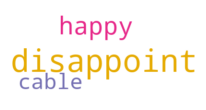

In [329]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

print(data_dtm)
for index, comedian in enumerate(data_dtm.columns):
    print(index, comedian)
    #print(top_dict[index])
    wc.generate(regeneration)
    index = 2
    plt.subplot(3, 4, index)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    #plt.title(full_names[index])
    
plt.show()

In [96]:
count = {}
for each in sumSamples:
    count[each] = 0
for each in sumSamples:
    count[each] = count[each] + 1
#count.items()

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
print(data)
data_cv = cv.fit_transform(data)
# good for count?
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
#data_dtm.index = data_clean.index
data_dtm

[['use', 'cable', 'run', 'output', 'pedal', 'chain', 'input', 'fender', 'amp'], ['buy', 'monster', 'cable', 'hook', 'pedal', 'board', 'think', 'would', 'try', 'another', 'one', 'update', 'guitar'], ['use', 'high', 'end', 'planet', 'wave', 'cable', 'buy', 'find', 'input', 'jack', 'new', 'monster', 'cable', 'fit', 'fender', 'strat', 'jack', 'little', 'disappoint', 'return', 'state', 'use', 'output', 'pedal', 'board'], ['save', 'money', 'go', 'back', 'planet', 'wave', 'cable', 'pay', 'back', 'eighties', 'planet', 'wave', 'come', 'around'], ['get', 'get', 'pay'], ['think', 'wave', 'lot', 'money', 'back', 'day', 'buy', 'guitar', 'cable', 'since', 'one', 'plus', 'years', 'still', 'work', 'planet', 'wave', 'win']]


AttributeError: 'list' object has no attribute 'lower'

In [413]:
#handling money
#>>> a = re.findall(r"\$\d+.\d+", text2)

In [236]:
#numeric and fraction handling
#domain specific if applies to tool/measurement?
pattern = re.compile(r'^\d+/\d+$')

def evaluateFraction(data, pattern=pattern):
    try:
        re.match(pattern, data)
        return eval(data)  
    except:
        print(f"Not fraction related input {data}")
        return False      

In [417]:
p = inflect.engine() 

isNum = evaluateFraction('1/2')
print(isNum)
if not (isNum == False):
    print(p.number_to_words(isNum))

0.5
zero point five


In [293]:
productsReviewData['cleanedText'] = productsReviewData['reviewText'].astype(str)
productsReviewData['cleanedText'] = productsReviewData['cleanedText'].str.lower()

df = productsReviewData

In [266]:
pd.options.display.max_colwidth = 5000

#productsReviewData.cleanedText.head(2)

In [121]:
sampleData = productsReviewData

In [416]:
productsReviewData.asin.nunique()

107

In [122]:
print(sampleData.asin.min())
print(sampleData.asin.max())

104800001X
B00LA96GLC


In [199]:
#pd.DataFrame(sampleData.groupby('asin')[['reviewerID'], ['helpful']])

7

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
